Step 1 - Import python libraries

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


Step 2 - Load and read the data file
1.   Upload data file from Google drive and run the notebook in the cloud
2.   Upload data file from local computer and run the notebook in the cloud
3.   Load data file from local computer and run the notebook locally

Step 2 - Option 1 - Upload data file from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#change the file name ("complete_COVID_samples.tsv") to your file name to load the data
df_samples = pd.read_table('/content/drive/MyDrive/complete_COVID_samples.tsv')
display(df_samples.head())

Step 2 - Option 2 - Upload data file from local computer

In [ ]:
from google.colab import files 
uploaded = files.upload()

In [ ]:
import io

#change the file name ("complete_COVID_samples.tsv") to your file name to load the data
df_samples = pd.read_table(io.BytesIO(uploaded['complete_samples.tsv']), sep = '\t')
display(df_samples.head())

Step 2 - Option 3 - Run the notebook locally (refer here for how to connect to local runtime https://research.google.com/colaboratory/local-runtimes.html)

In [7]:
# Use the `outputPath` variable to set the path to your data.
outputPath = "../../../../Documents/complete_COVID_samples.tsv"

df_samples = pd.read_table(outputPath, sep = '\t', low_memory=False, engine="c")
display(df_samples.head())

,sample,frequency,templates,amino_acid,rearrangement,v_resolved,d_resolved,j_resolved,age,gender,...,icu_admit,birth_year,blood_type,cmv_at_donation,days_from_last_symptom_to_sample,ethnicity,height_meters,hospitalized,weight_kg,race
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,72,Male,...,False,1948,ab neg,NEG,26.0,not hispanic/latino,1.778,True,95.24,Caucasian


Step 3 - Create the standardized format (column content and column names)
1.   Sample name (sample)
2.   Clone frequency (freq)
3.   Clone reads count (#count)
4.   CDR3 amino acid clonotype (cdr3aa)
5.   CDR3 nucleotide (cdr3nt)
6.   V gene (v)
7.   D gene (d)
8.   J gene (j)
9.   Optional - Sample feature (here we use hospitalization as the clinical feature)

In [8]:
#select the columns that are listed above
df_samples = df_samples[['sample','frequency', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]
#rename the columns
df_samples.columns = ['sample', 'freq' , '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalization']
display(df_samples.head())

,sample,freq,#count,cdr3aa,cdr3nt,v,d,j,hospitalization
0,6232BW_TCRB,0.006751,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True
1,6232BW_TCRB,0.005639,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True
2,6232BW_TCRB,0.004258,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True
3,6232BW_TCRB,0.003639,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True
4,6232BW_TCRB,0.003521,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True


Prepare two dataframes for merging and analyzing the overlapping

In [9]:
# if there are more than one V or J gene, leave only the first one
df_samples['v'].str.replace("(,).*", "", regex=True)
df_samples['j'].str.replace("(,).*", "", regex=True)

df_compare = pd.merge(df_samples, df_samples, on=[
                      'cdr3nt', 'cdr3aa', 'v', 'd', 'j'], suffixes=['_1', '_2'])

df_compare['#count_1**2'] = df_compare['#count_1'] * df_compare['#count_1']
df_compare['#count_2**2'] = df_compare['#count_2'] * df_compare['#count_2']
df_compare['#count_1*2'] = df_compare['#count_1'] * df_compare['#count_2']

# Prepare data for future analysis
sample_names = df_samples["sample"].drop_duplicates()
sample_names_size = sample_names.size
sample_names.index = np.arange(0, sample_names_size)

samples = {}

for sample in sample_names:
    filtered_samples = df_samples.loc[(df_samples['sample'] == sample)]
    samples[sample] = filtered_samples


In [10]:
# Compute and store pairwise sample overlaps for quick lookup
df_overlaps = {}

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    df_compare1 = (df_compare['sample_1'] == sample1)

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_compare2 = (df_compare['sample_2'] == sample2)

        df_rows = df_compare.loc[df_compare1 & df_compare2]
        df_overlaps[f'{sample1}:{sample2}'] = df_rows


Overlap analysis 1.1 - Jaccard index (result table)

In [11]:
# create an empty dataframe for storing results
df_jaccard_index = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'jaccard_index'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        jaccard_overlap = df_overlaps[f'{sample1}:{sample2}'].shape[0]

        # Calculate Jaccard Index
        jaccard = jaccard_overlap / \
            (df_sample1.shape[0] + df_sample2.shape[0] - jaccard_overlap)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jaccard_index': jaccard})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jaccard_index': jaccard})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_jaccard_index = pd.concat([df_jaccard_index, df_data])

df_jaccard_index


,sample_1,sample_2,jaccard_index
0,6232BW_TCRB,5115BW_TCRB,0.000473
0,5115BW_TCRB,6232BW_TCRB,0.000473
0,6232BW_TCRB,989003BW_TCRB,0.000636
0,989003BW_TCRB,6232BW_TCRB,0.000636
0,6232BW_TCRB,7972BW_TCRB,0.000500
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.001046
0,1566449BW_TCRB,1566265BW_TCRB,0.001195
0,1566265BW_TCRB,1566449BW_TCRB,0.001195
0,3602BW_TCRB,1566265BW_TCRB,0.001129


Overlap analysis 1.2 - Jaccard index (heatmap)

Text(0.5, 1.0, 'jaccard_index')

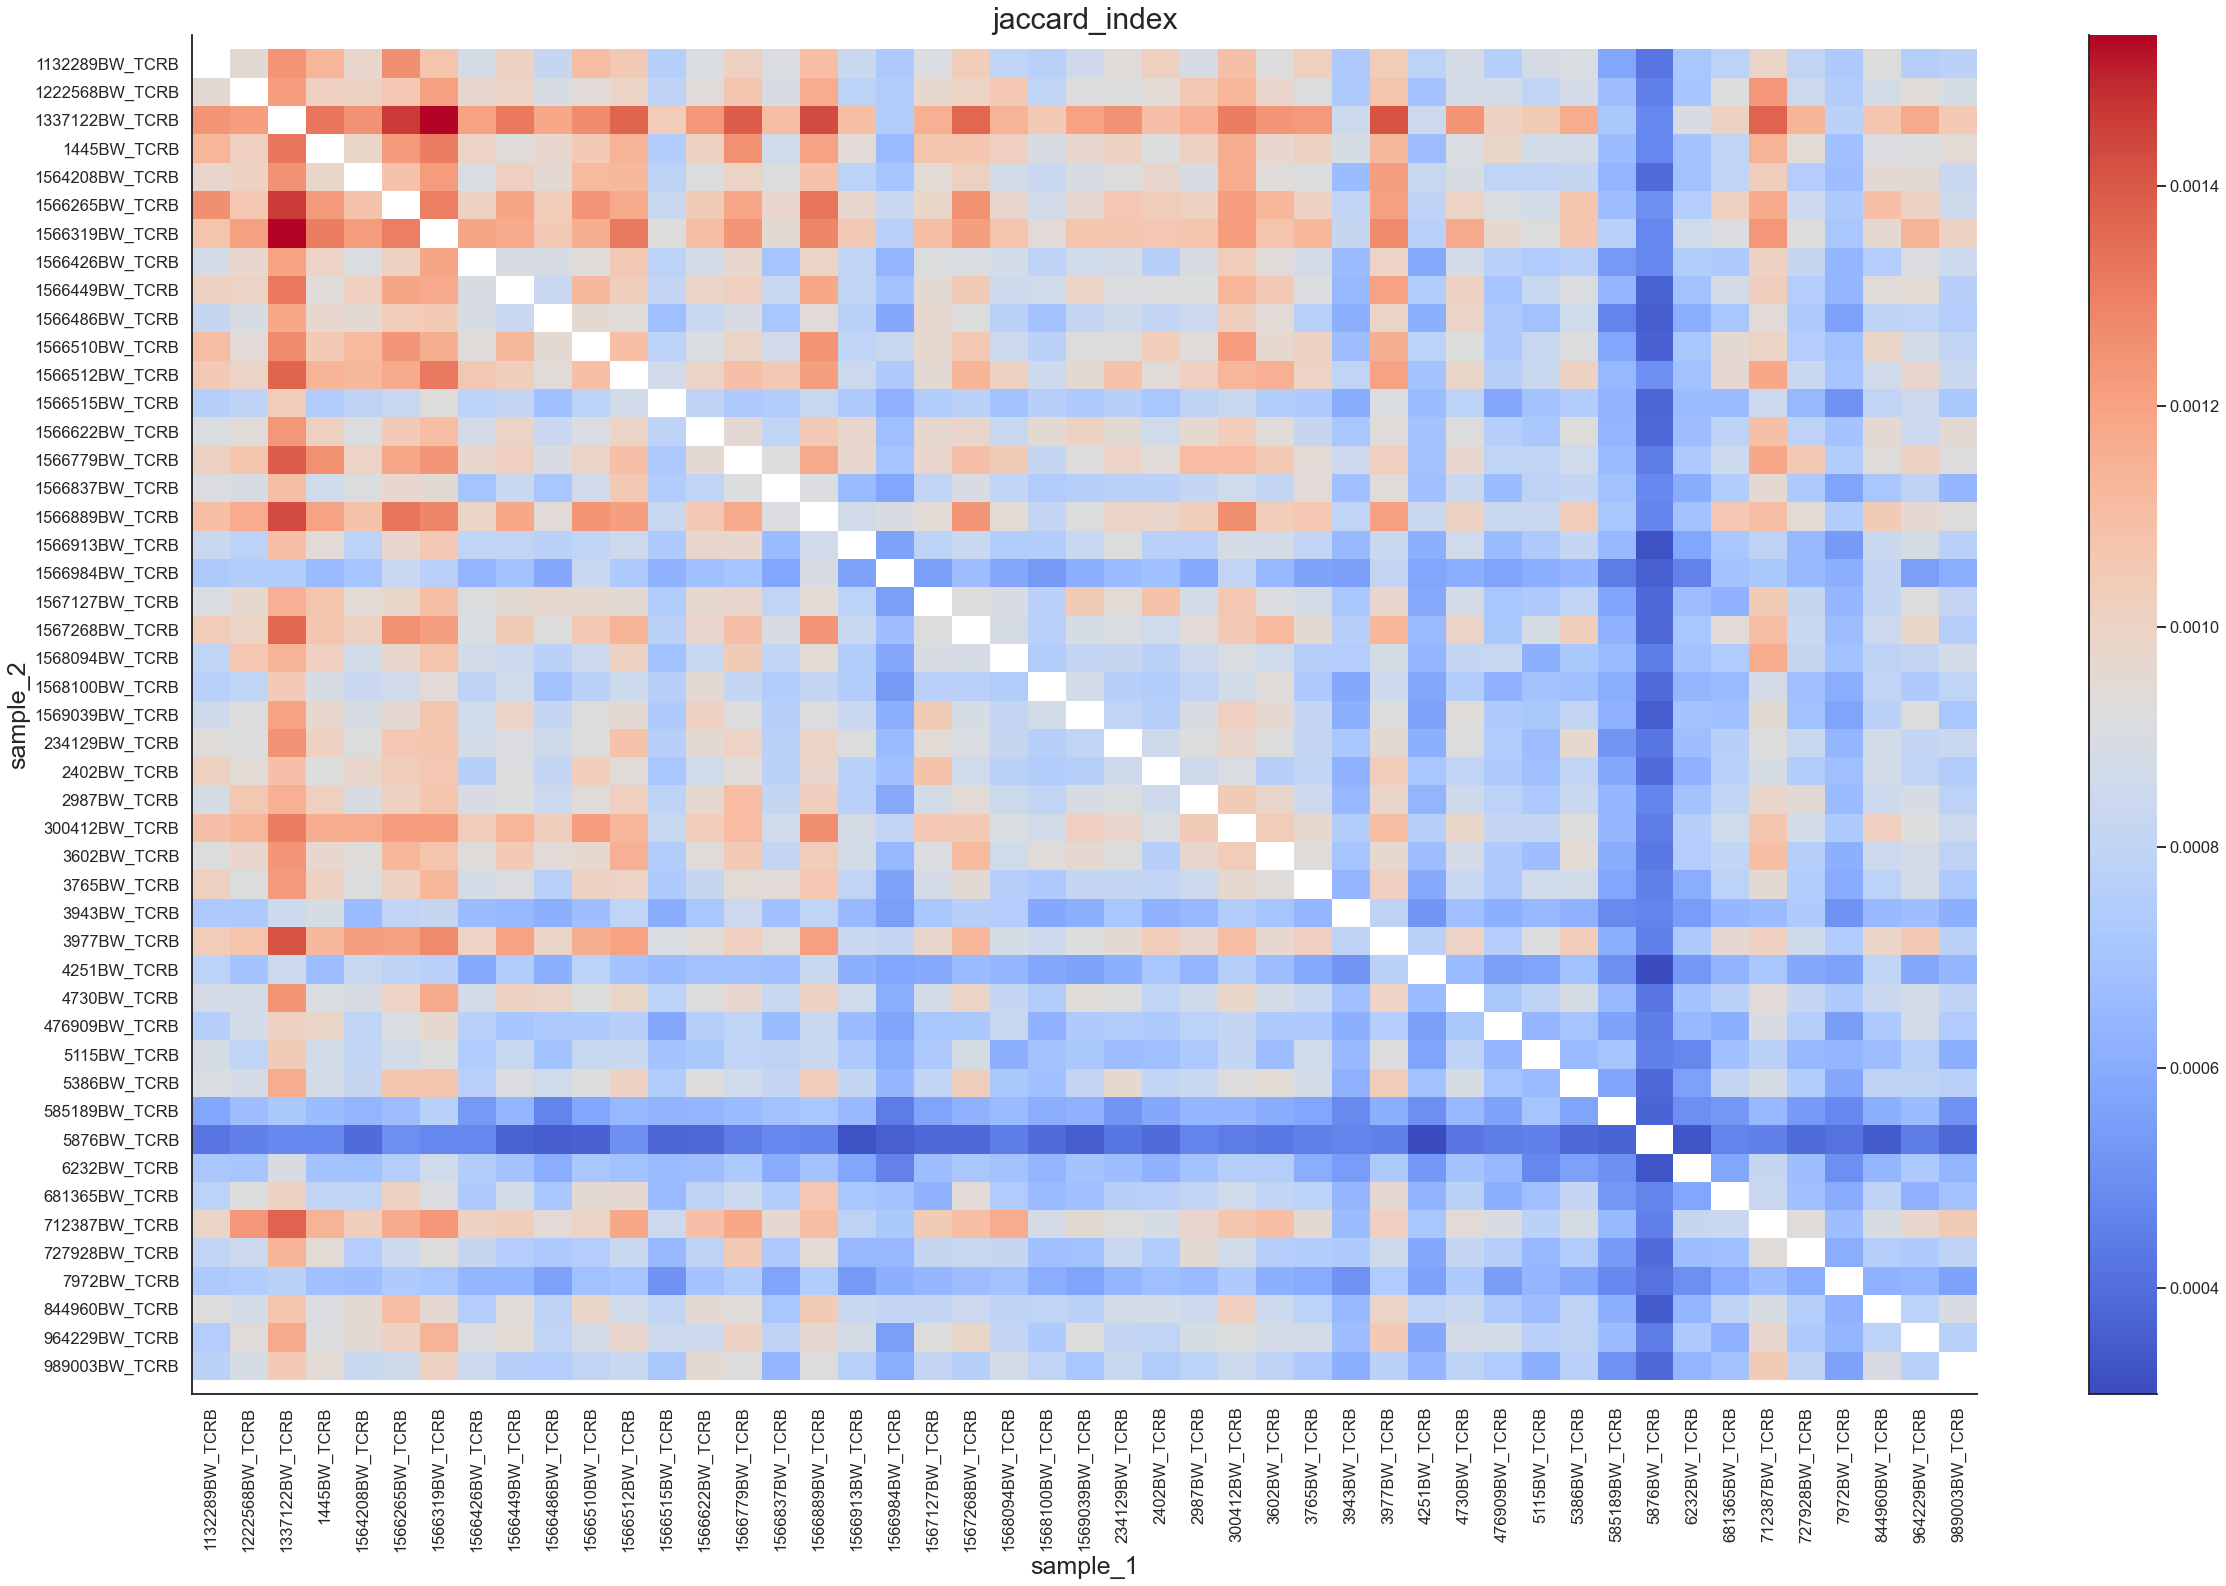

In [12]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_jaccard_index['jaccard_index'] = df_jaccard_index['jaccard_index'].astype(
    float)

result = df_jaccard_index.pivot(
    index='sample_2', columns='sample_1', values='jaccard_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=25)
ax.set_ylabel('sample_2', fontsize=25)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('jaccard_index', fontsize=30)


Overlap analysis 2.1 - Overlap coefficient (result table)

In [14]:
# create an empty dataframe for storing results
df_overlap_coefficient = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'overlap_coefficient'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample2]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        # Calculate Overlap Coefficient
        overlap_coefficient = sample_overlap.shape[0] / \
            min(df_sample1.shape[0], df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'overlap_coefficient': overlap_coefficient})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'overlap_coefficient': overlap_coefficient})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_overlap_coefficient = pd.concat([df_overlap_coefficient, df_data])

df_overlap_coefficient


,sample_1,sample_2,overlap_coefficient
0,6232BW_TCRB,5115BW_TCRB,0.000945
0,5115BW_TCRB,6232BW_TCRB,0.000945
0,6232BW_TCRB,989003BW_TCRB,0.001058
0,989003BW_TCRB,6232BW_TCRB,0.001058
0,6232BW_TCRB,7972BW_TCRB,0.001130
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.002049
0,1566449BW_TCRB,1566265BW_TCRB,0.002156
0,1566265BW_TCRB,1566449BW_TCRB,0.002156
0,3602BW_TCRB,1566265BW_TCRB,0.002075


Overlap analysis 2.2 - Overlap coefficient (heatmap)

Text(0.5, 1.0, 'Overlap_coefficient')

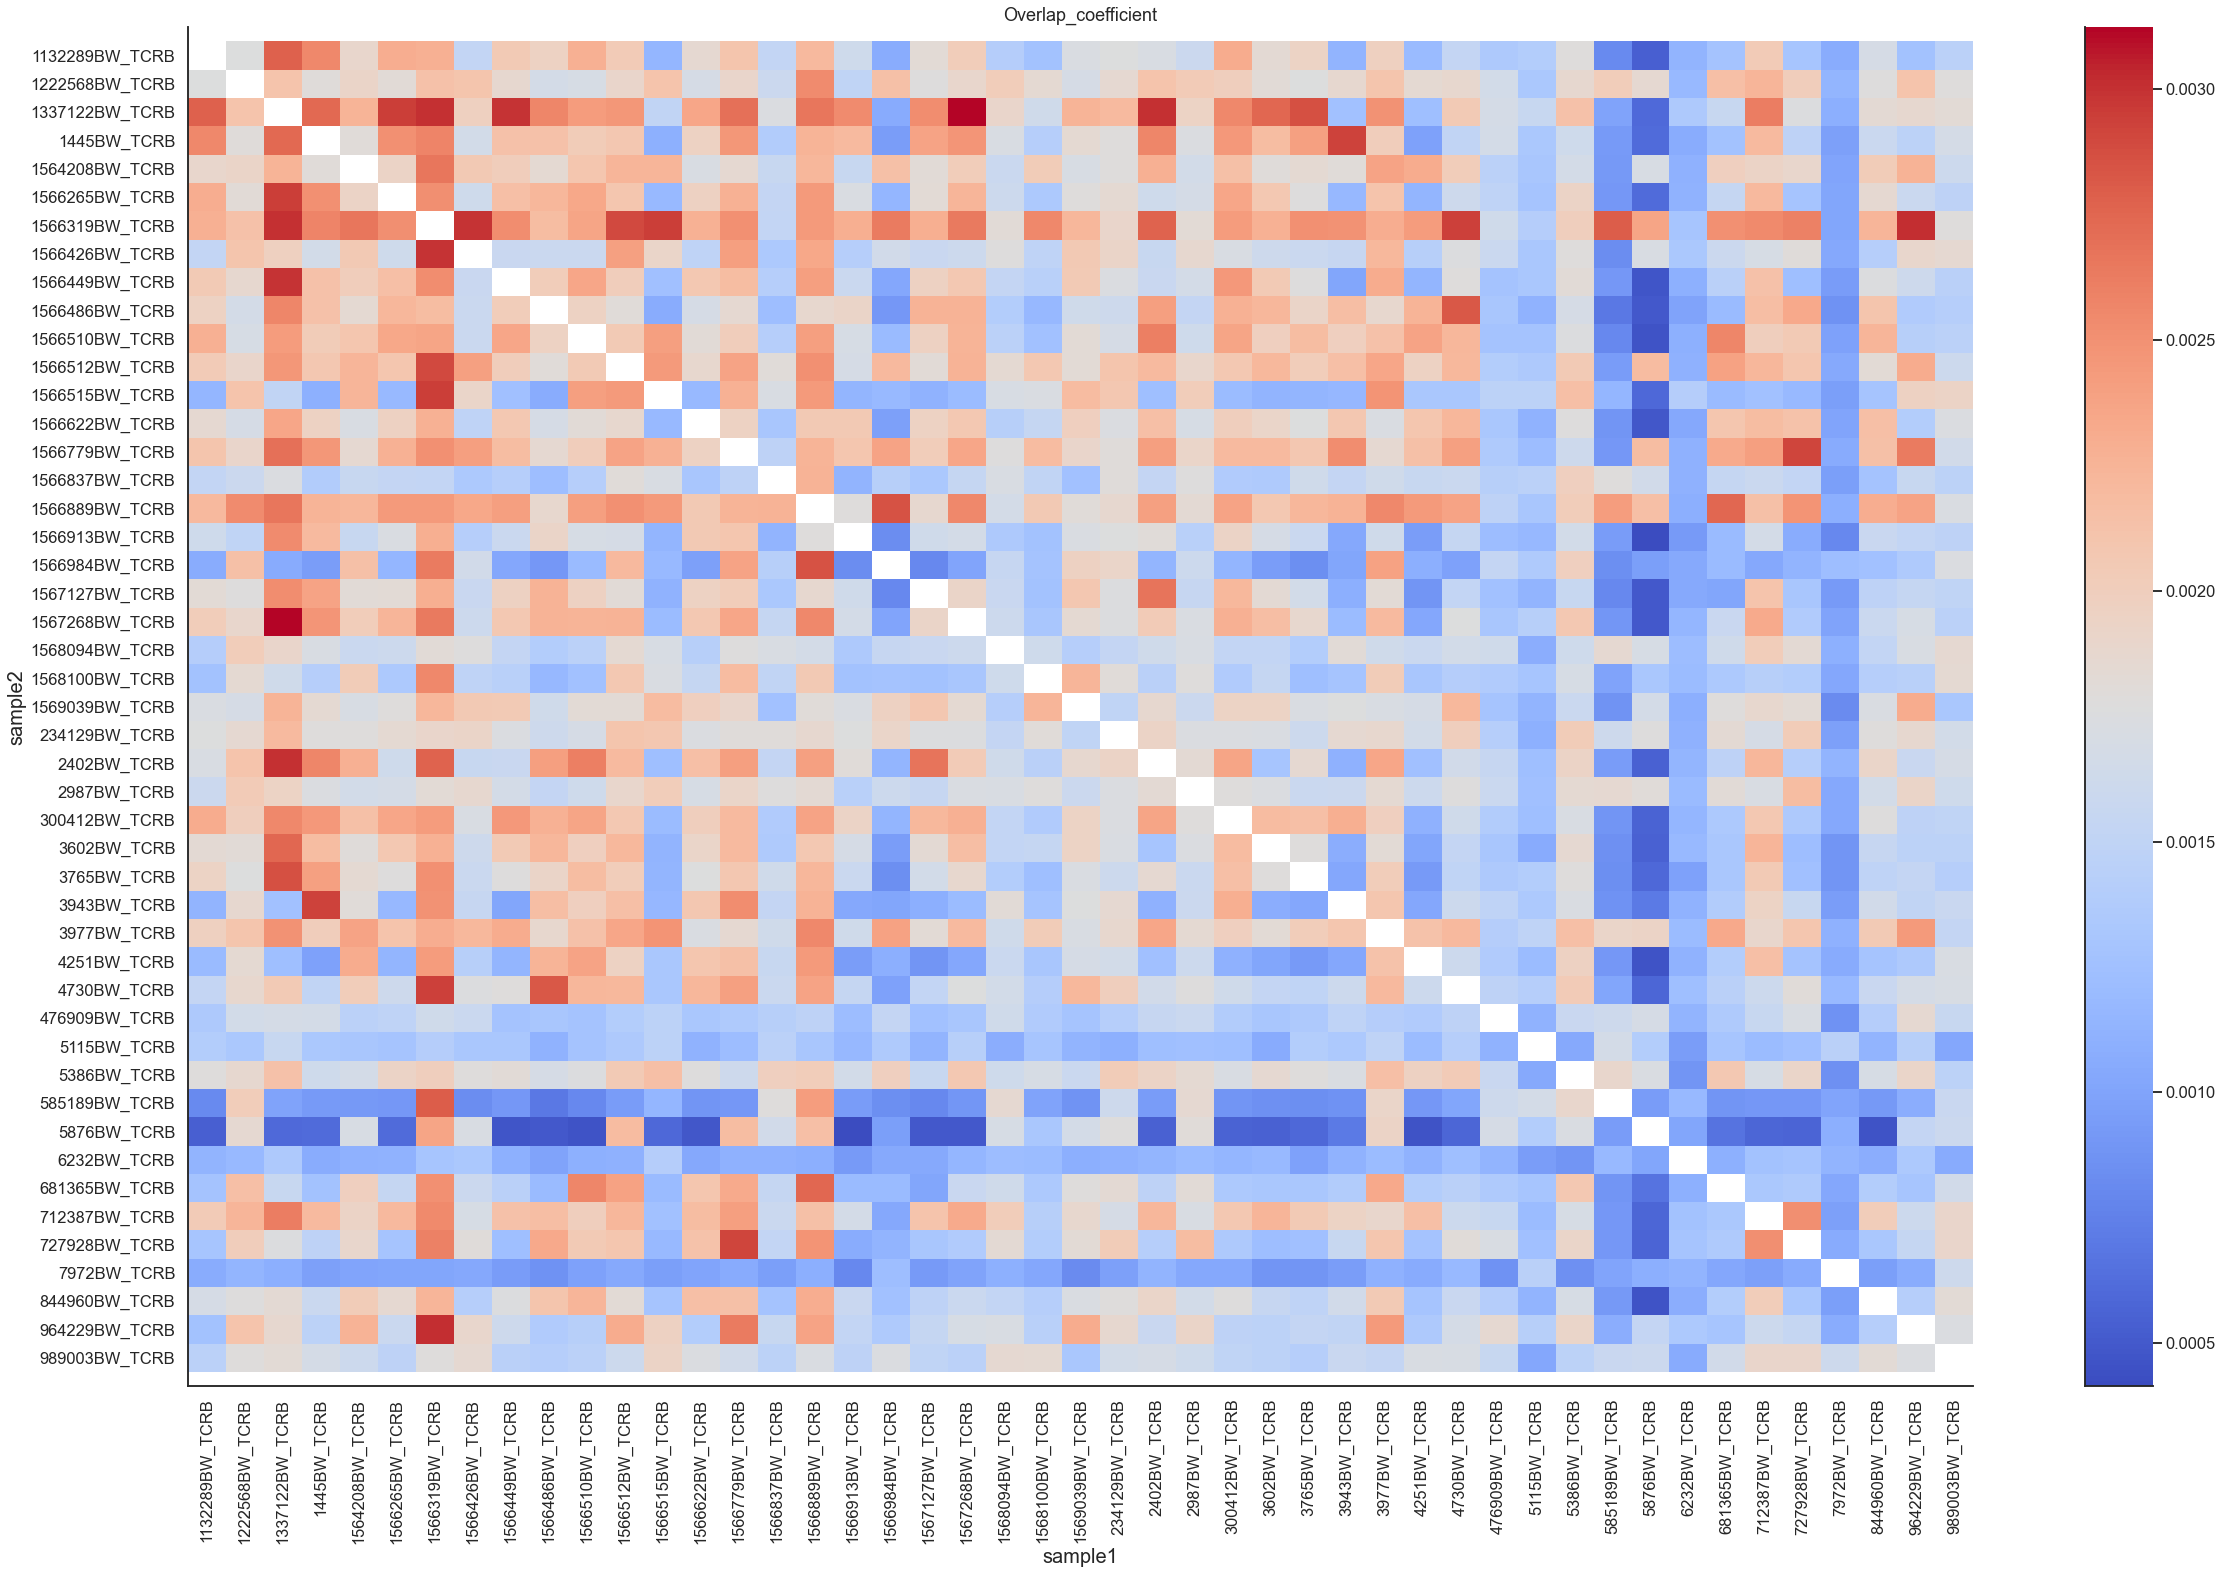

In [15]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_overlap_coefficient['overlap_coefficient'] = df_overlap_coefficient['overlap_coefficient'].astype(
    float)

result = df_overlap_coefficient.pivot(
    index='sample_2', columns='sample_1', values='overlap_coefficient')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample1', fontsize=20)
ax.set_ylabel('sample2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Overlap_coefficient')


Overlap analysis 3.1 - Morisita-Horn index (result table)

In [16]:
# create an empty dataframe for storing results
df_morisita_horm_index = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'morisita_horn_index'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sum_sample_1_count = df_sample1["#count"].sum()
        sum_sample_2_count = df_sample2["#count"].sum()

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']

        sum_sample_1 = sample_overlap["#count_1**2"].sum()
        sum_sample_2 = sample_overlap["#count_2**2"].sum()

        sum_count_product = sample_overlap["#count_1*2"].sum()

        # #calculate Morisita-Horn index
        step1 = (sum_sample_1 / ((sum_sample_1_count)**2)) + \
            (sum_sample_2 / ((sum_sample_2_count)**2))
        step2 = step1 * sum_sample_1_count * sum_sample_2_count
        step3 = 2 * sum_count_product
        morisita_horn_index = step3 / step2

        # #store the results
        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'morisita_horn_index': morisita_horn_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'morisita_horn_index': morisita_horn_index})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_morisita_horm_index = pd.concat(
        [df_morisita_horm_index, df_data], copy=False)

display(df_morisita_horm_index)


,sample_1,sample_2,morisita_horn_index
0,6232BW_TCRB,5115BW_TCRB,0.185901
0,5115BW_TCRB,6232BW_TCRB,0.185901
0,6232BW_TCRB,989003BW_TCRB,0.194270
0,989003BW_TCRB,6232BW_TCRB,0.194270
0,6232BW_TCRB,7972BW_TCRB,0.150494
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.025197
0,1566449BW_TCRB,1566265BW_TCRB,0.129856
0,1566265BW_TCRB,1566449BW_TCRB,0.129856
0,3602BW_TCRB,1566265BW_TCRB,0.141251


Overlap analysis 3.2 - Morisita-Horn index (heatmap)

Text(0.5, 1.0, 'morisita_horn_index')

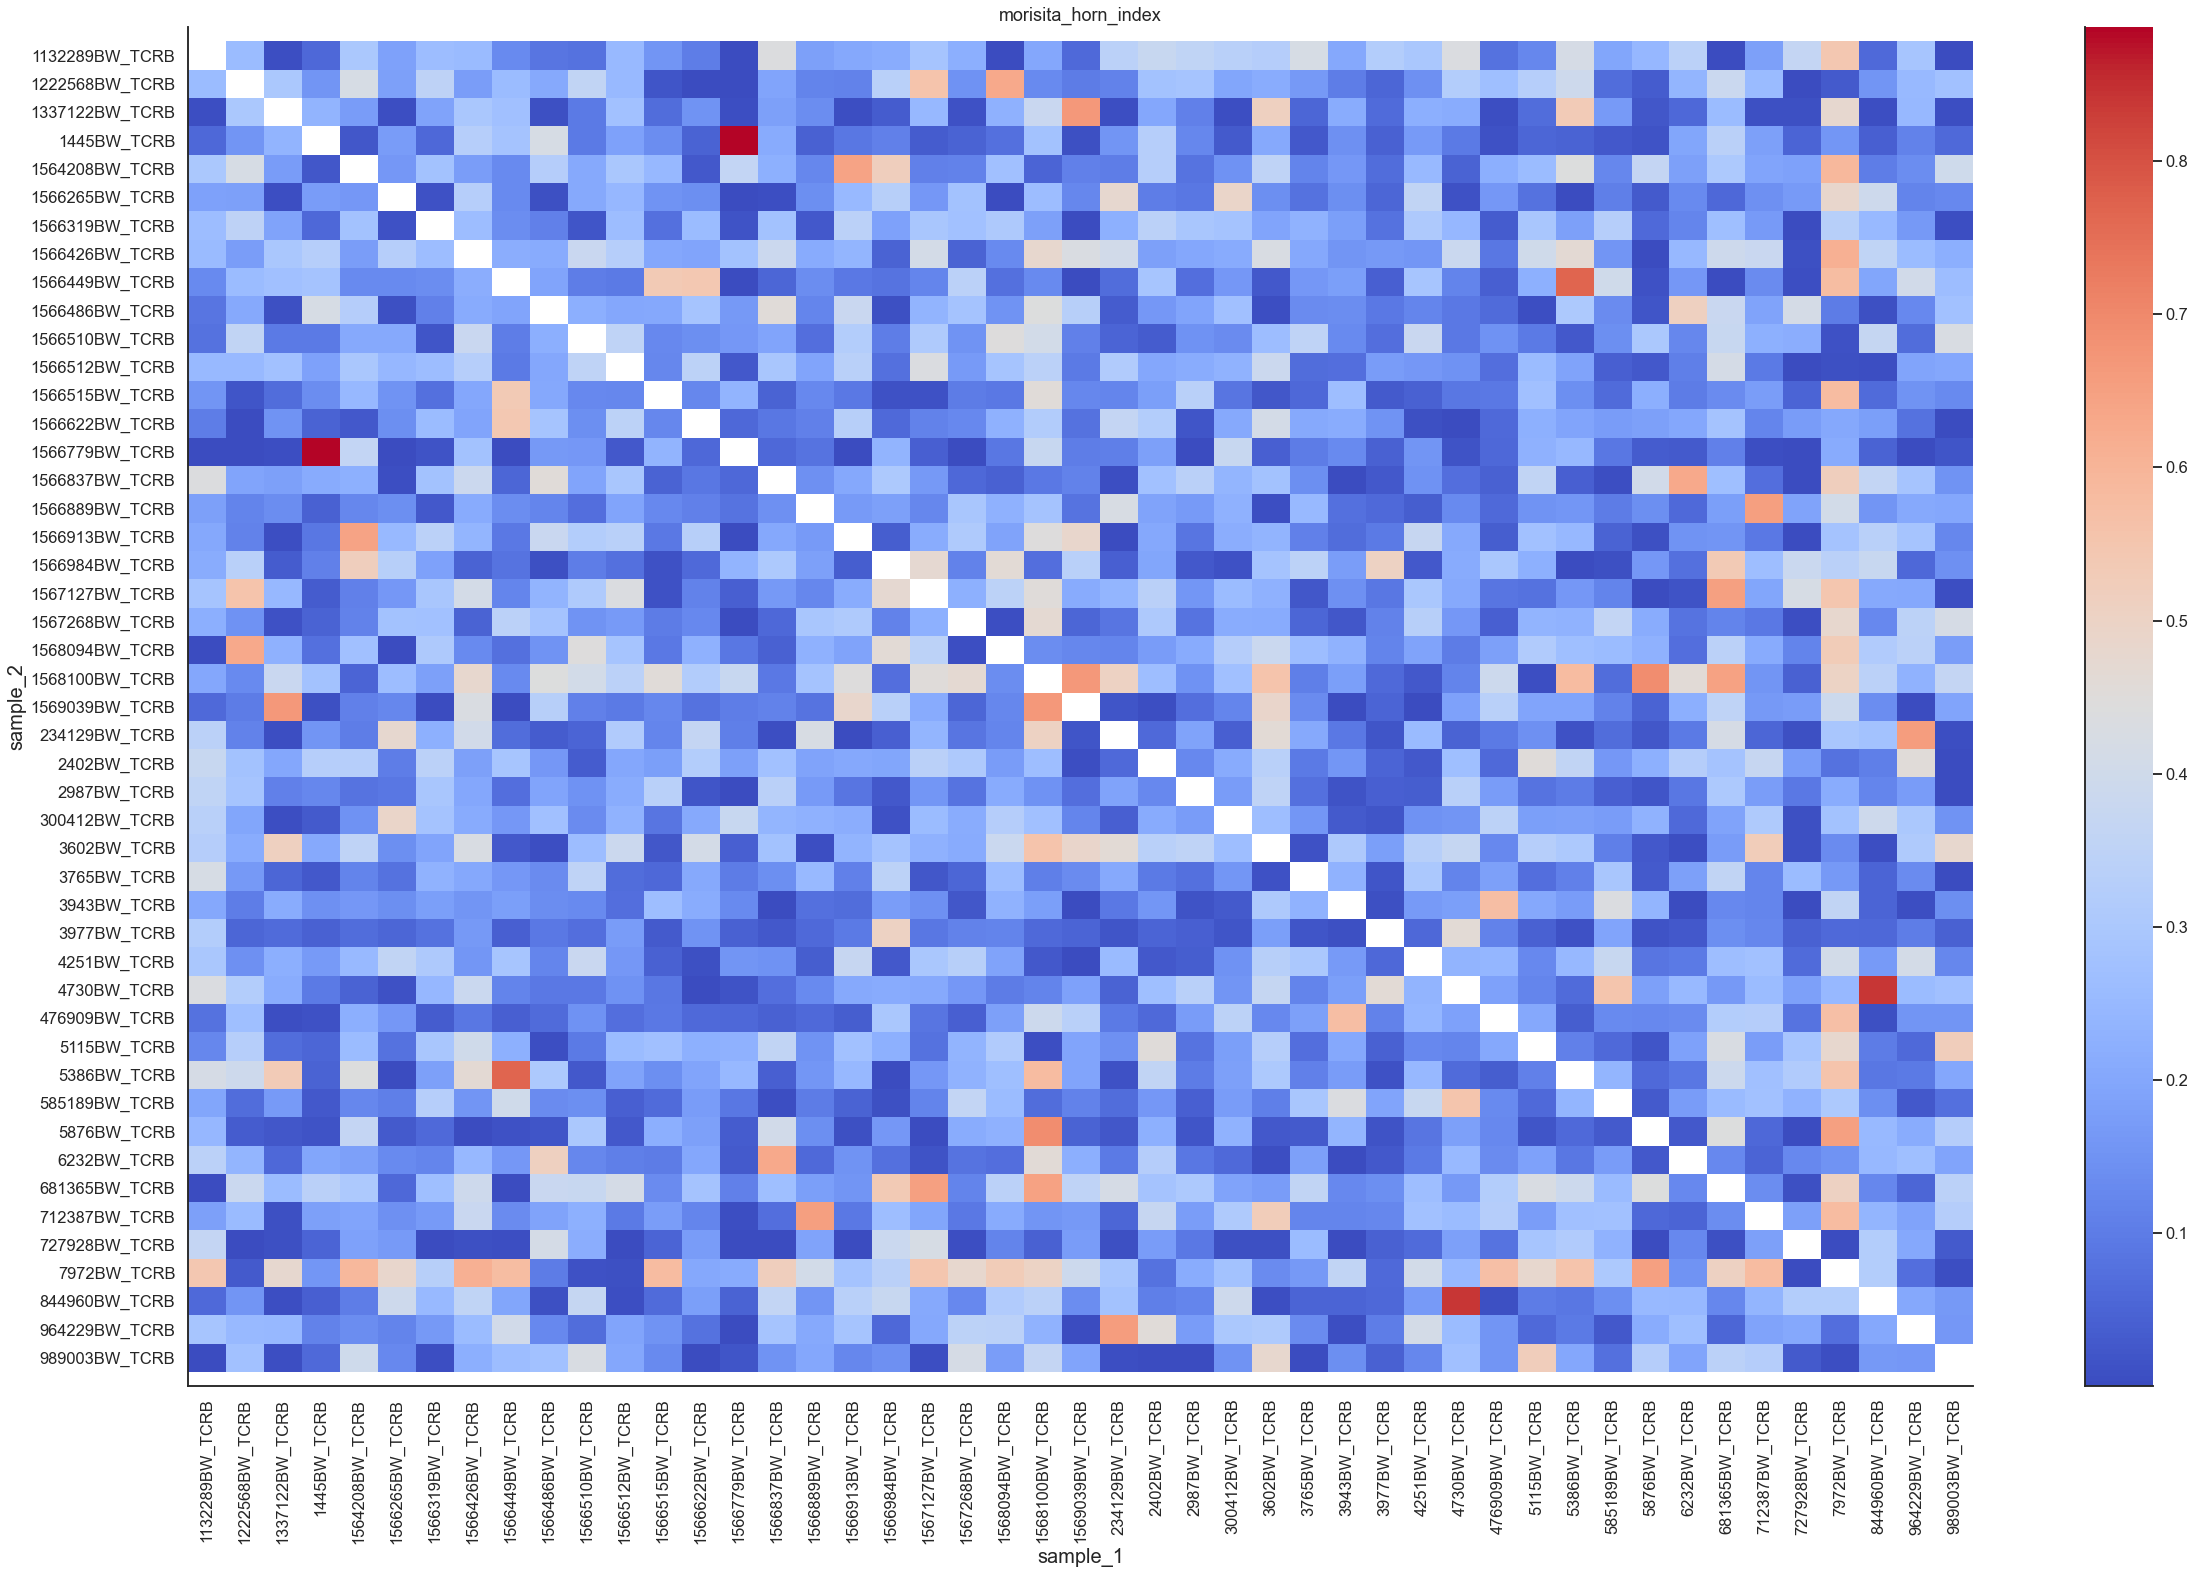

In [17]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_morisita_horm_index['morisita_horn_index'] = df_morisita_horm_index['morisita_horn_index'].astype(
    float)

result = df_morisita_horm_index.pivot(
    index='sample_2', columns='sample_1', values='morisita_horn_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('morisita_horn_index')


Overlap analysis 4.1 - Tversky index (result table)


In [18]:
df_tversky_index = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'tversky_index'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        tversky_index = df_overlap.shape[0] / (df_overlap.shape[0] + 0.5 * (
            df_sample1.shape[0] - df_overlap.shape[0]) + 0.5 * (df_sample2.shape[0] - df_overlap.shape[0]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'tversky_index': tversky_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'tversky_index': tversky_index})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_tversky_index = pd.concat([df_tversky_index, df_data], copy=False)

display(df_tversky_index)


,sample_1,sample_2,tversky_index
0,6232BW_TCRB,5115BW_TCRB,0.000945
0,5115BW_TCRB,6232BW_TCRB,0.000945
0,6232BW_TCRB,989003BW_TCRB,0.001270
0,989003BW_TCRB,6232BW_TCRB,0.001270
0,6232BW_TCRB,7972BW_TCRB,0.000999
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.002090
0,1566449BW_TCRB,1566265BW_TCRB,0.002386
0,1566265BW_TCRB,1566449BW_TCRB,0.002386
0,3602BW_TCRB,1566265BW_TCRB,0.002255


Overlap analysis 4.2 - Tversky index (heatmap)

Text(0.5, 1.0, 'tversky_index')

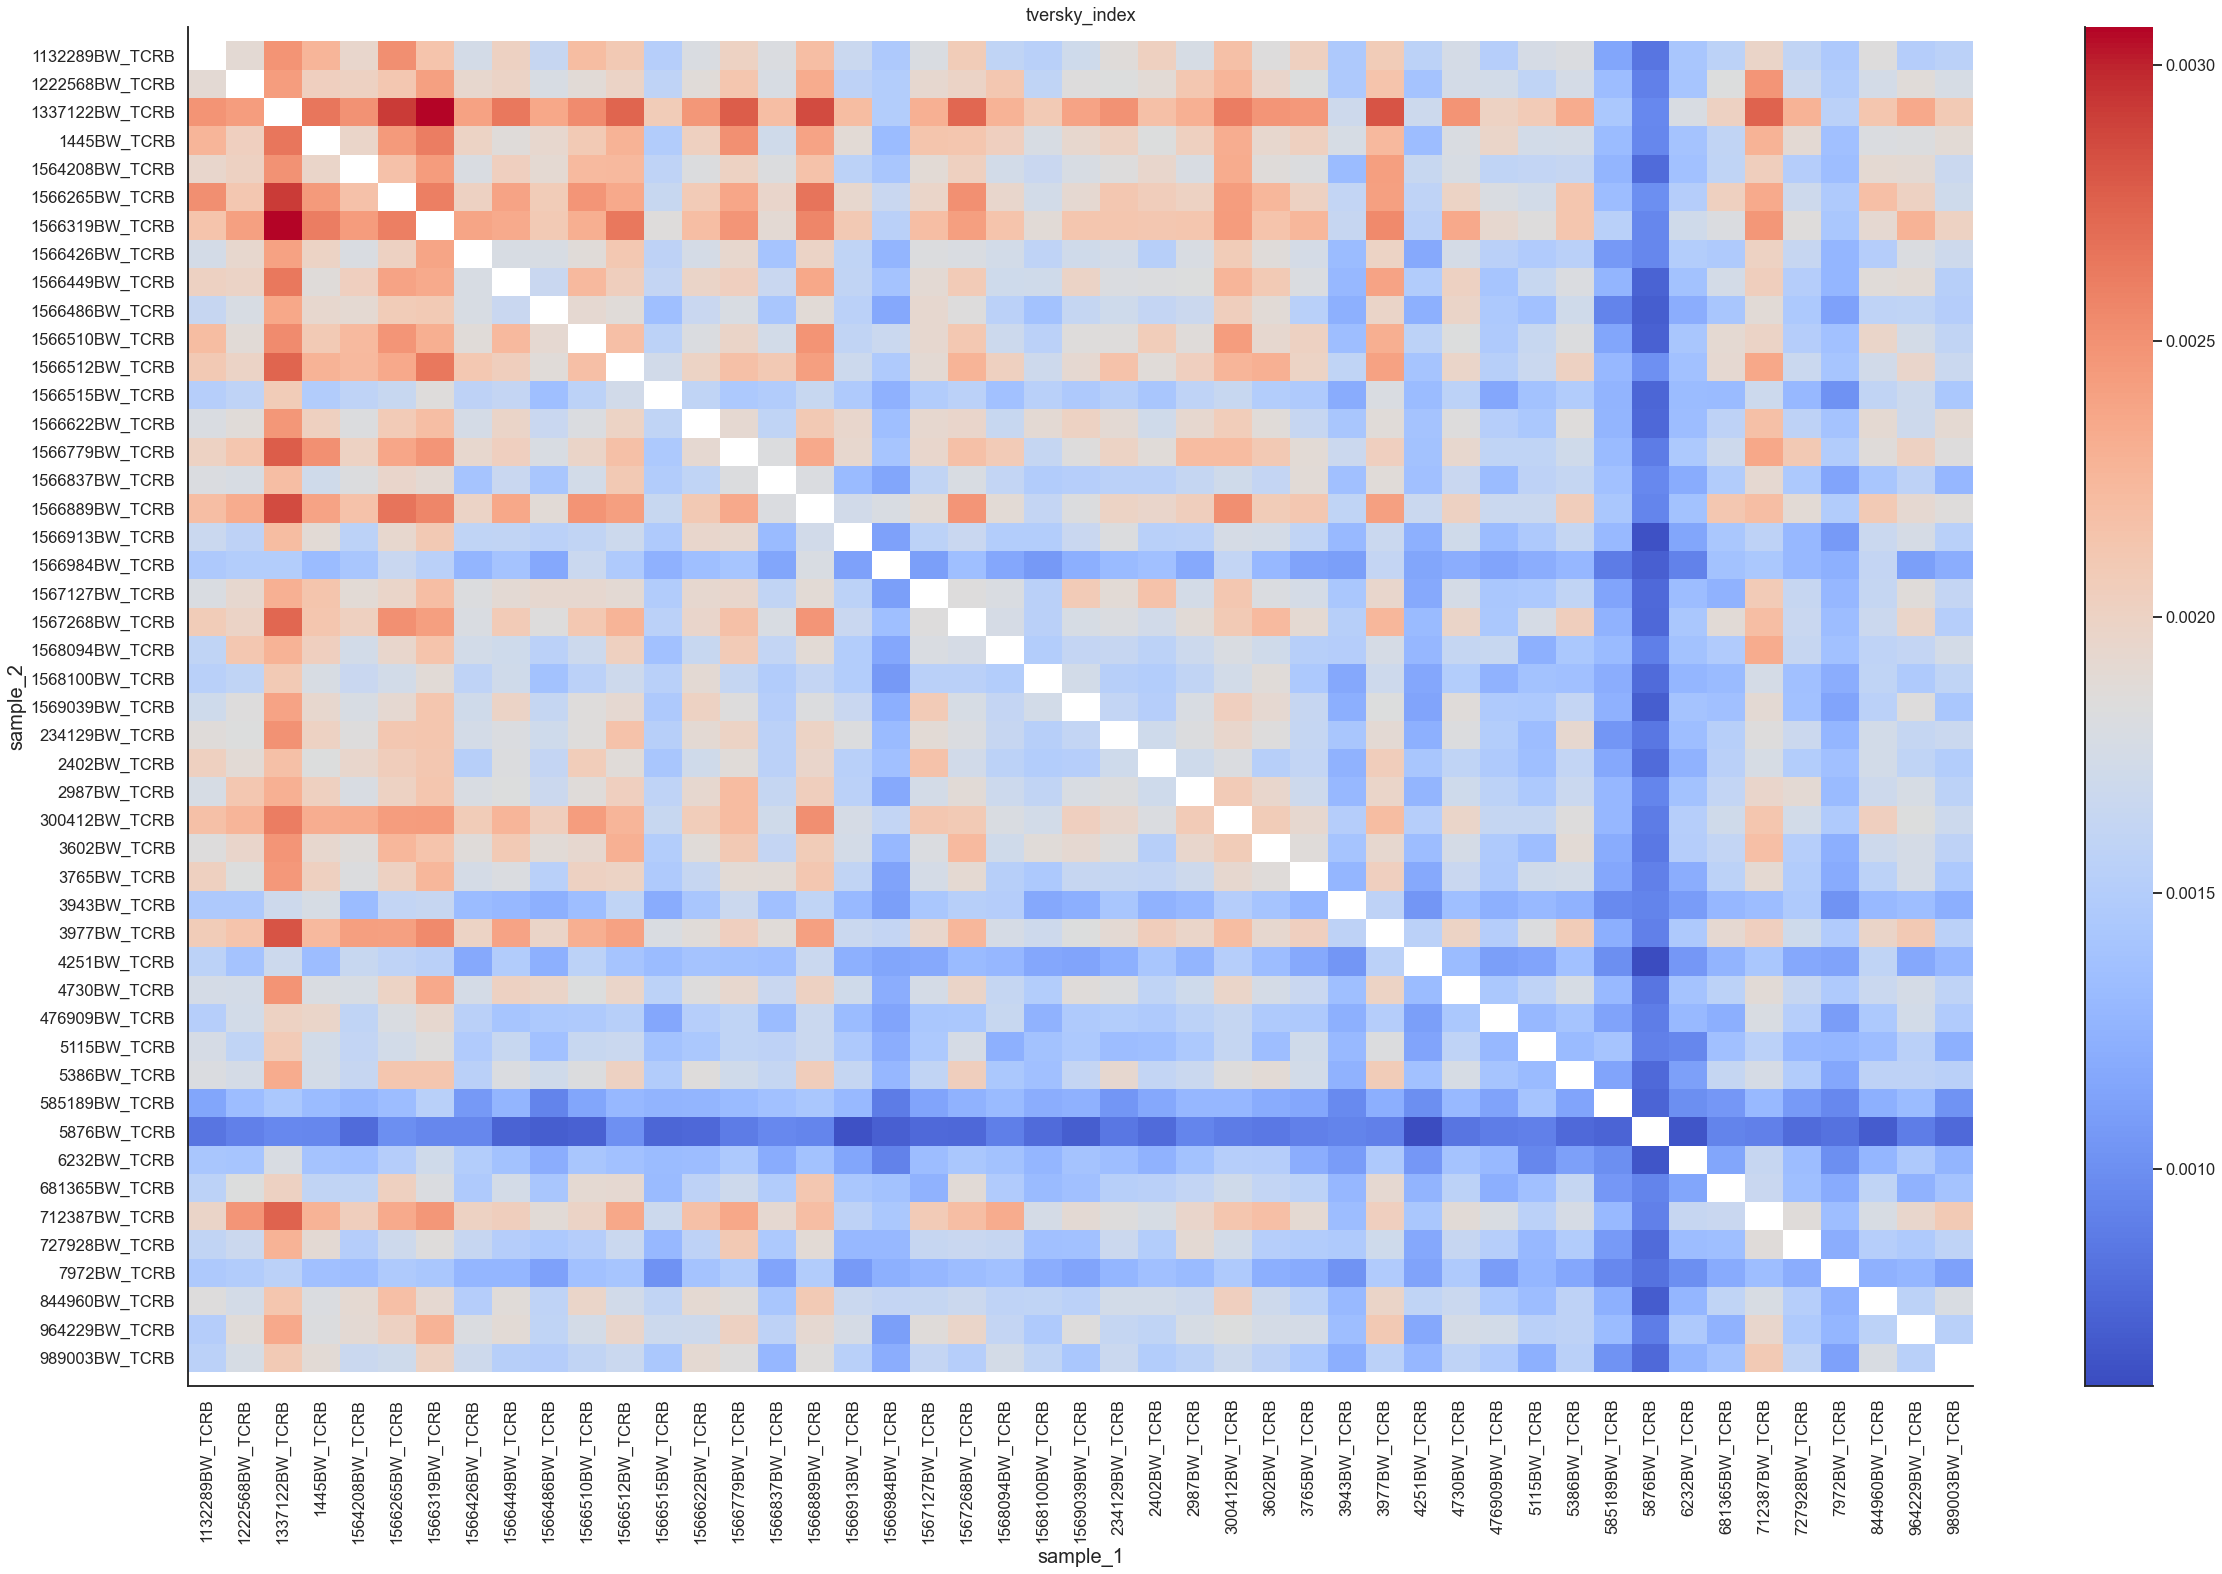

In [19]:
#set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40,25))
sns.set_style("white")
sns.set_context("talk")

#generate axes
df_tversky_index['Tversky_index'] = df_tversky_index['tversky_index'].astype(float)
result = df_tversky_index.pivot(index='sample_2',columns='sample_1',values='tversky_index')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1',fontsize=20)
ax.set_ylabel('sample_2',fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('tversky_index')

Overlap analysis 5.1 - Cosine similarity (result table)

In [22]:
from scipy.spatial.distance import cosine

columns = ['sample_1', 'sample_2', 'cosine_similarity']
df_cosine_similarity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        cos_vec = (1 - cosine(df_overlap["freq_1"], df_overlap["freq_2"]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'cosine_similarity': cos_vec})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'cosine_similarity': cos_vec})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_cosine_similarity = pd.concat(
        [df_cosine_similarity, df_data], copy=False)

display(df_cosine_similarity)


,sample_1,sample_2,cosine_similarity
0,6232BW_TCRB,5115BW_TCRB,0.352216
0,5115BW_TCRB,6232BW_TCRB,0.352216
0,6232BW_TCRB,989003BW_TCRB,0.203431
0,989003BW_TCRB,6232BW_TCRB,0.203431
0,6232BW_TCRB,7972BW_TCRB,0.157580
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.066429
0,1566449BW_TCRB,1566265BW_TCRB,0.217962
0,1566265BW_TCRB,1566449BW_TCRB,0.217962
0,3602BW_TCRB,1566265BW_TCRB,0.177322


Overlap analysis 5.2 - Cosine similarity (heatmap)

Text(0.5, 1.0, 'cosine_similarity')

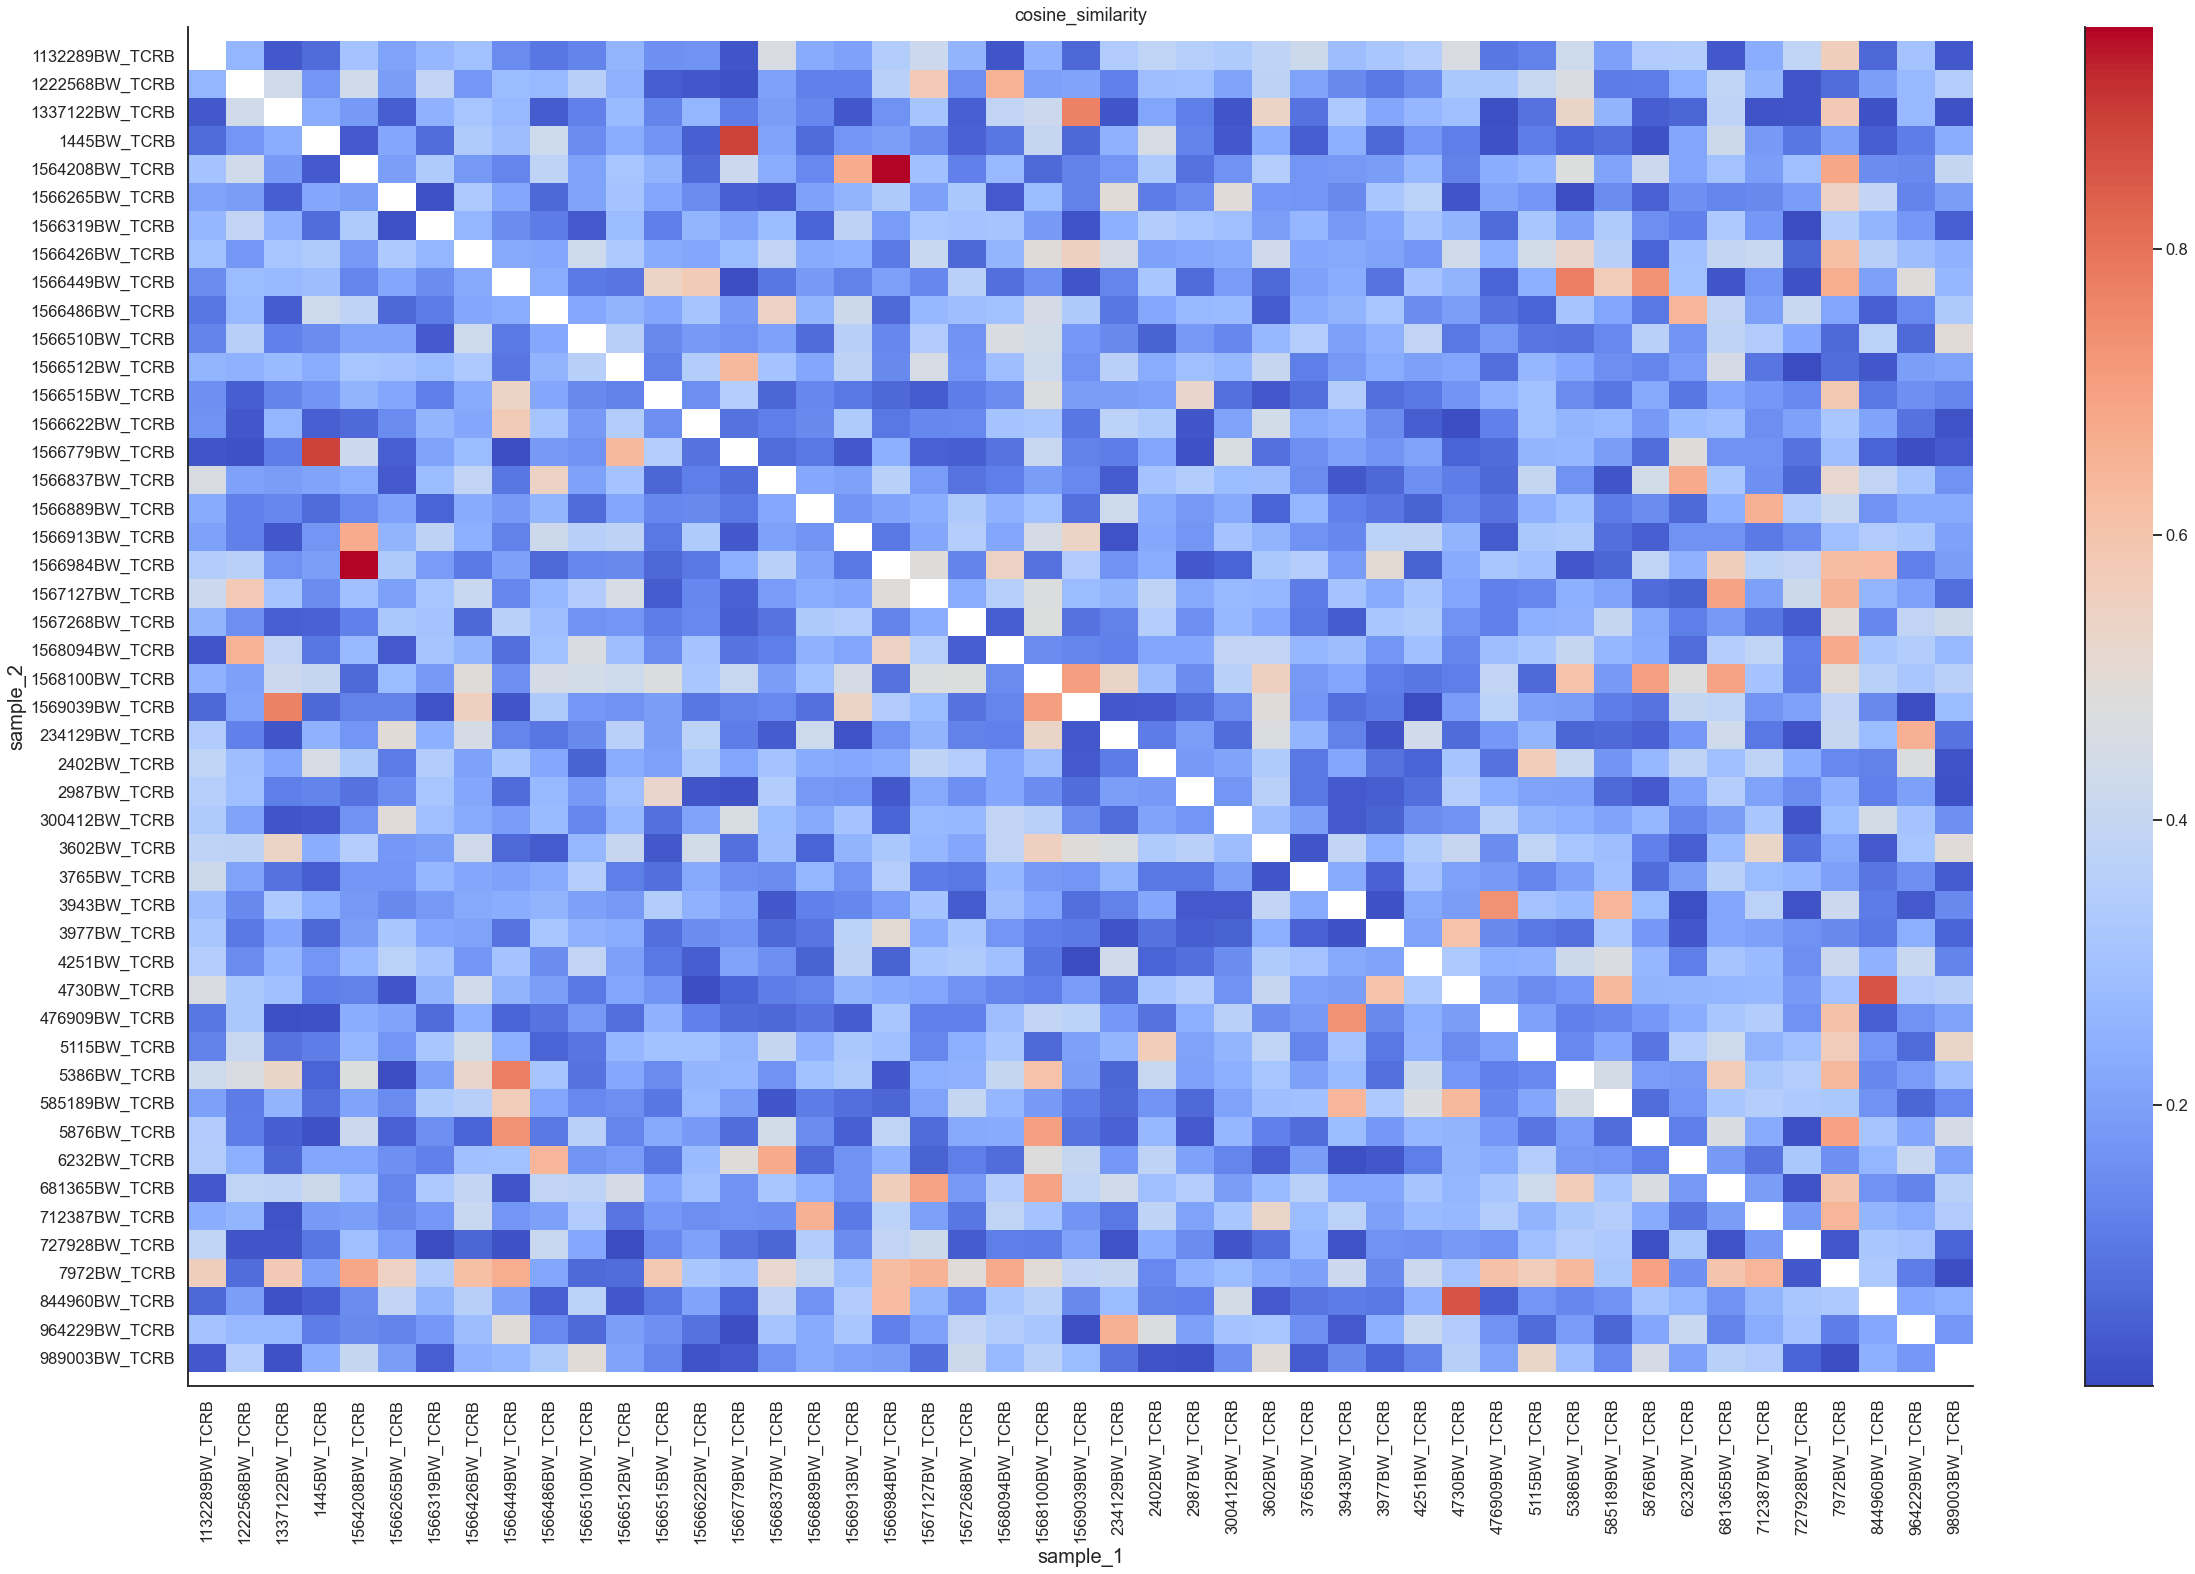

In [23]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_cosine_similarity['cosine_similarity'] = df_cosine_similarity['cosine_similarity'].astype(
    float)

result = df_cosine_similarity.pivot(
    index='sample_2', columns='sample_1', values='cosine_similarity')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('cosine_similarity')


Overlap analysis 6.1.1 - Pearson correlation based on clonotype counts (result table)

In [28]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_count = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation = df_overlap['#count_1'].corr(
            df_overlap['#count_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_pearson_correlation_count = pd.concat(
        [df_pearson_correlation_count, df_data], copy=False)

display(df_pearson_correlation_count)


,sample_1,sample_2,pearson_correlation
0,6232BW_TCRB,5115BW_TCRB,0.129897
0,5115BW_TCRB,6232BW_TCRB,0.129897
0,6232BW_TCRB,989003BW_TCRB,-0.011675
0,989003BW_TCRB,6232BW_TCRB,-0.011675
0,6232BW_TCRB,7972BW_TCRB,-0.011471
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.049247
0,1566449BW_TCRB,1566265BW_TCRB,0.125340
0,1566265BW_TCRB,1566449BW_TCRB,0.125340
0,3602BW_TCRB,1566265BW_TCRB,0.021052


Overlap analysis 6.1.2 - Pearson correlation based on clonotype counts (heatmap)

Text(0.5, 1.0, 'pearson_correlation')

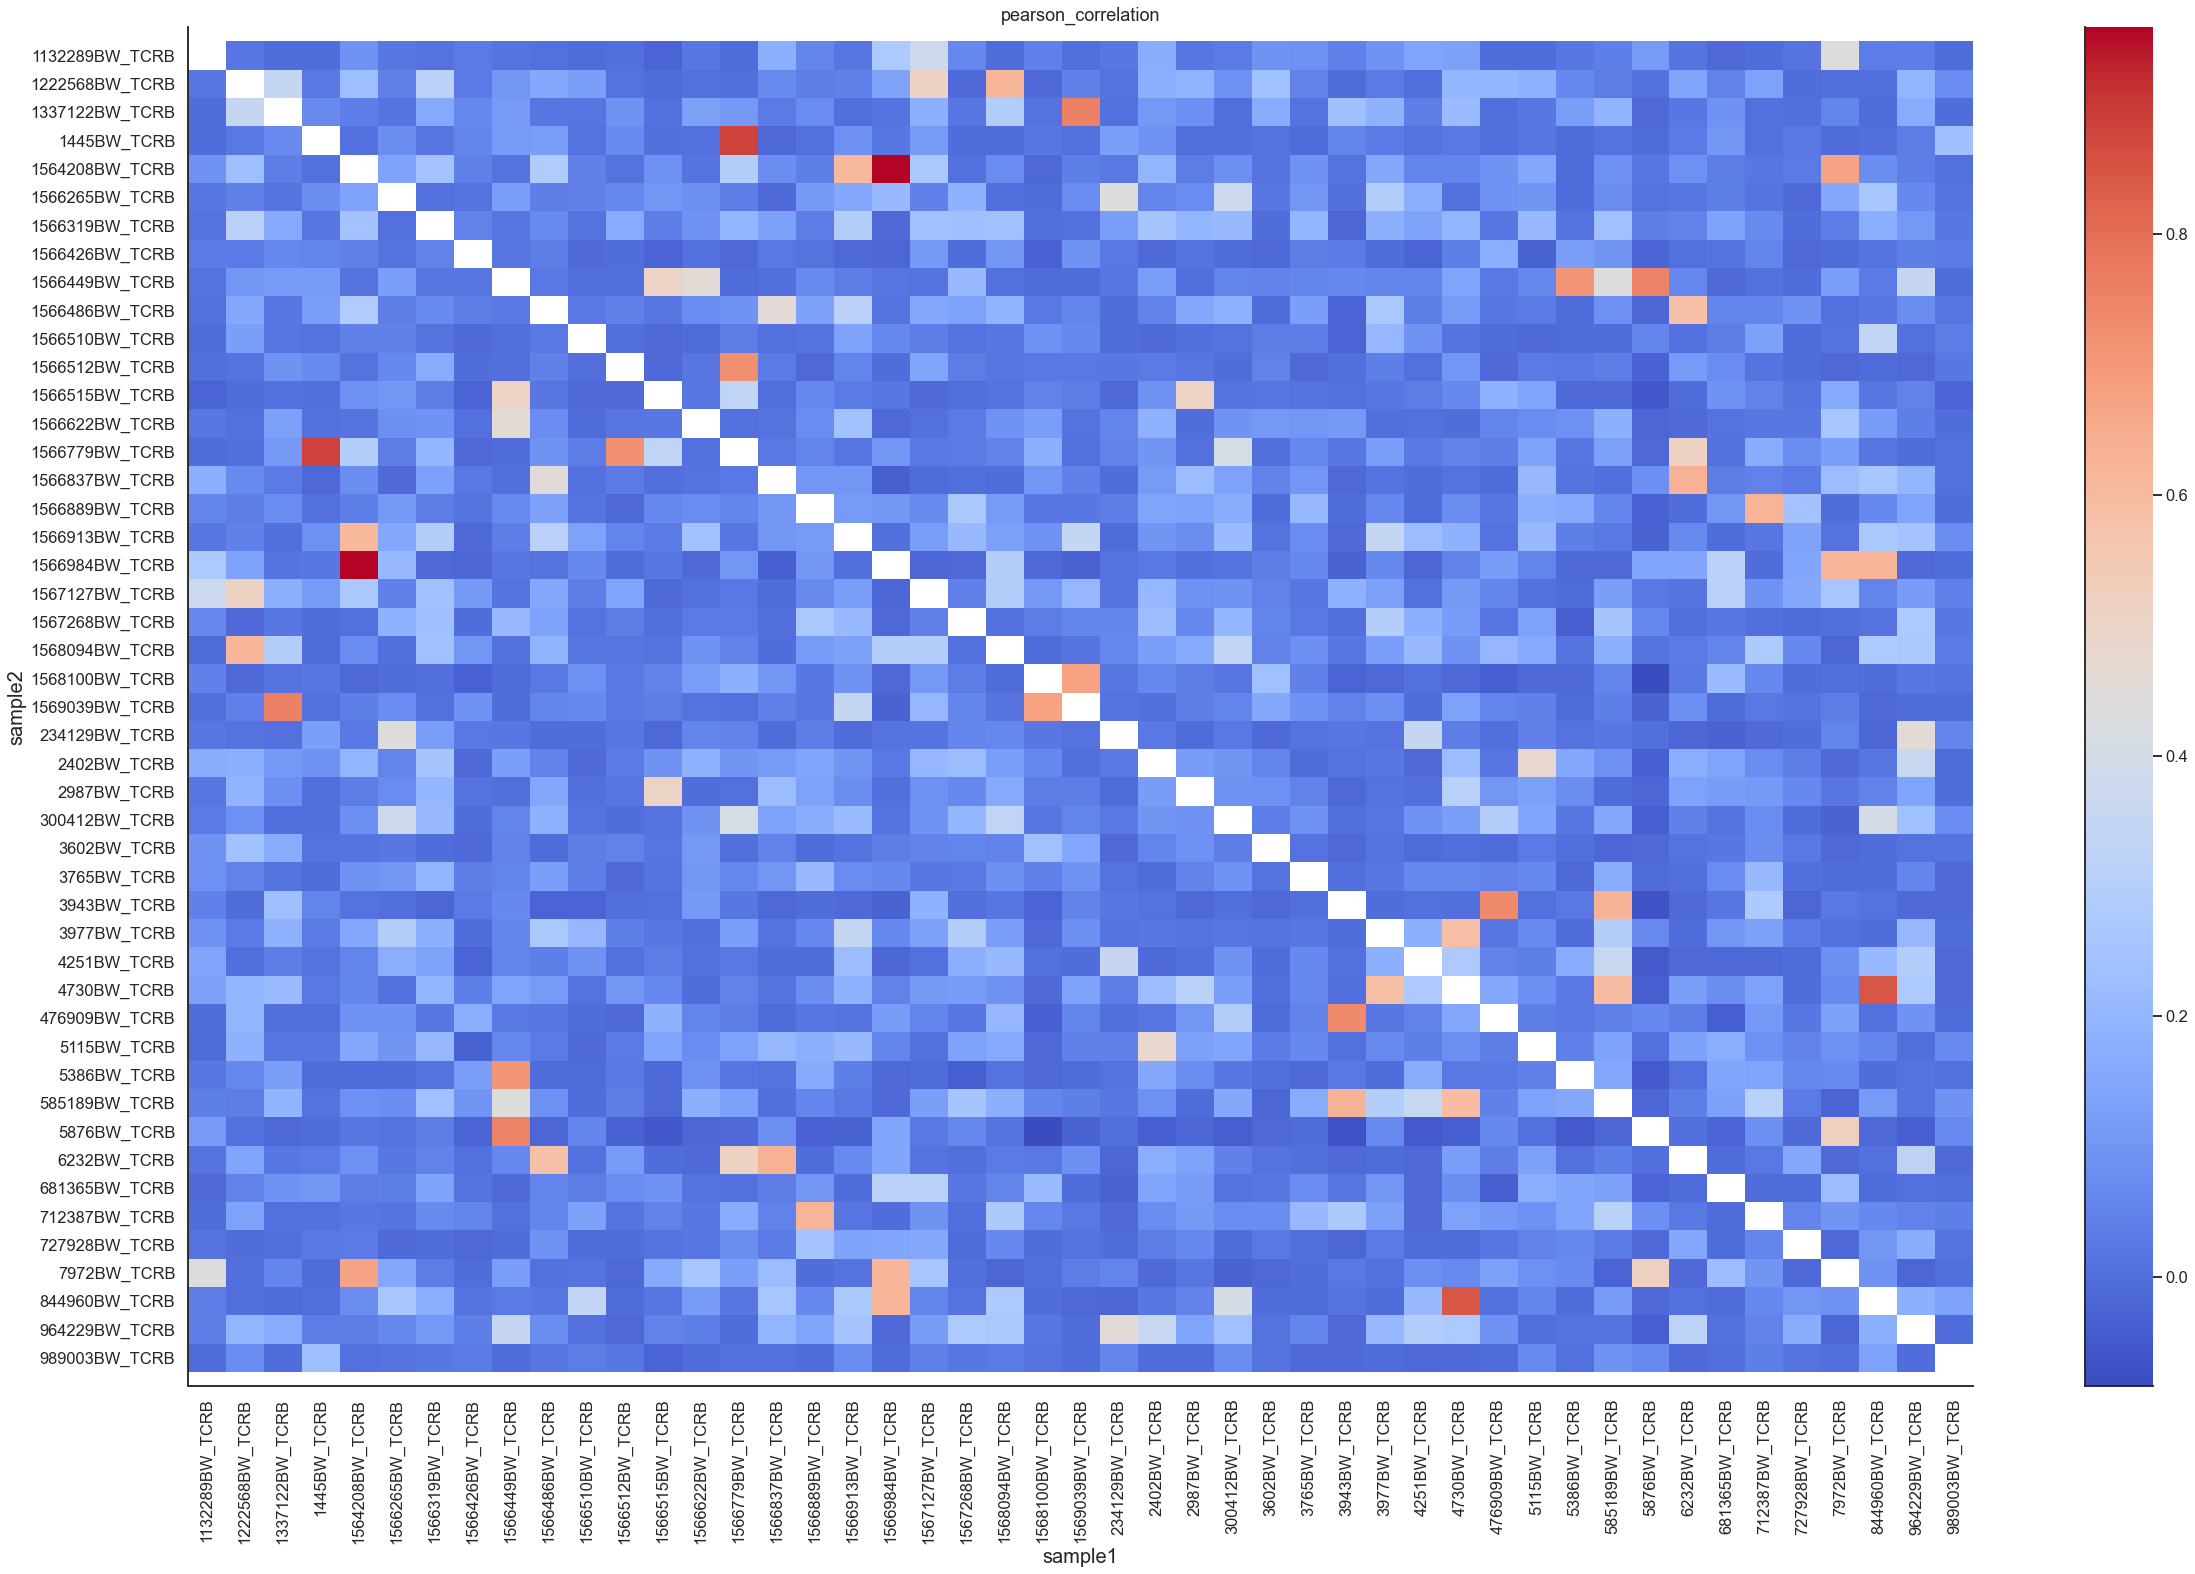

In [29]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_pearson_correlation_count['pearson_correlation'] = df_pearson_correlation_count['pearson_correlation'].astype(
    float)

result = df_pearson_correlation_count.pivot(
    index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample1', fontsize=20)
ax.set_ylabel('sample2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('pearson_correlation')


Overlap analysis 6.2.1 - Pearson correlation based on clonotype frequency (result table)

In [30]:
df_pearson_correlation_freq = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'pearson_correlation'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation_freq = df_overlap['freq_1'].corr(
            df_overlap['freq_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation_freq})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation_freq})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_pearson_correlation_freq = pd.concat(
        [df_pearson_correlation_freq, df_data], copy=False)

display(df_pearson_correlation_freq)


,sample_1,sample_2,pearson_correlation
0,6232BW_TCRB,5115BW_TCRB,0.129897
0,5115BW_TCRB,6232BW_TCRB,0.129897
0,6232BW_TCRB,989003BW_TCRB,-0.011675
0,989003BW_TCRB,6232BW_TCRB,-0.011675
0,6232BW_TCRB,7972BW_TCRB,-0.011471
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.049247
0,1566449BW_TCRB,1566265BW_TCRB,0.125340
0,1566265BW_TCRB,1566449BW_TCRB,0.125340
0,3602BW_TCRB,1566265BW_TCRB,0.021052


Overlap analysis 6.2.2 - Pearson correlation based on clonotype frequency (heatmap)

Text(0.5, 1.0, 'pearson_correlation')

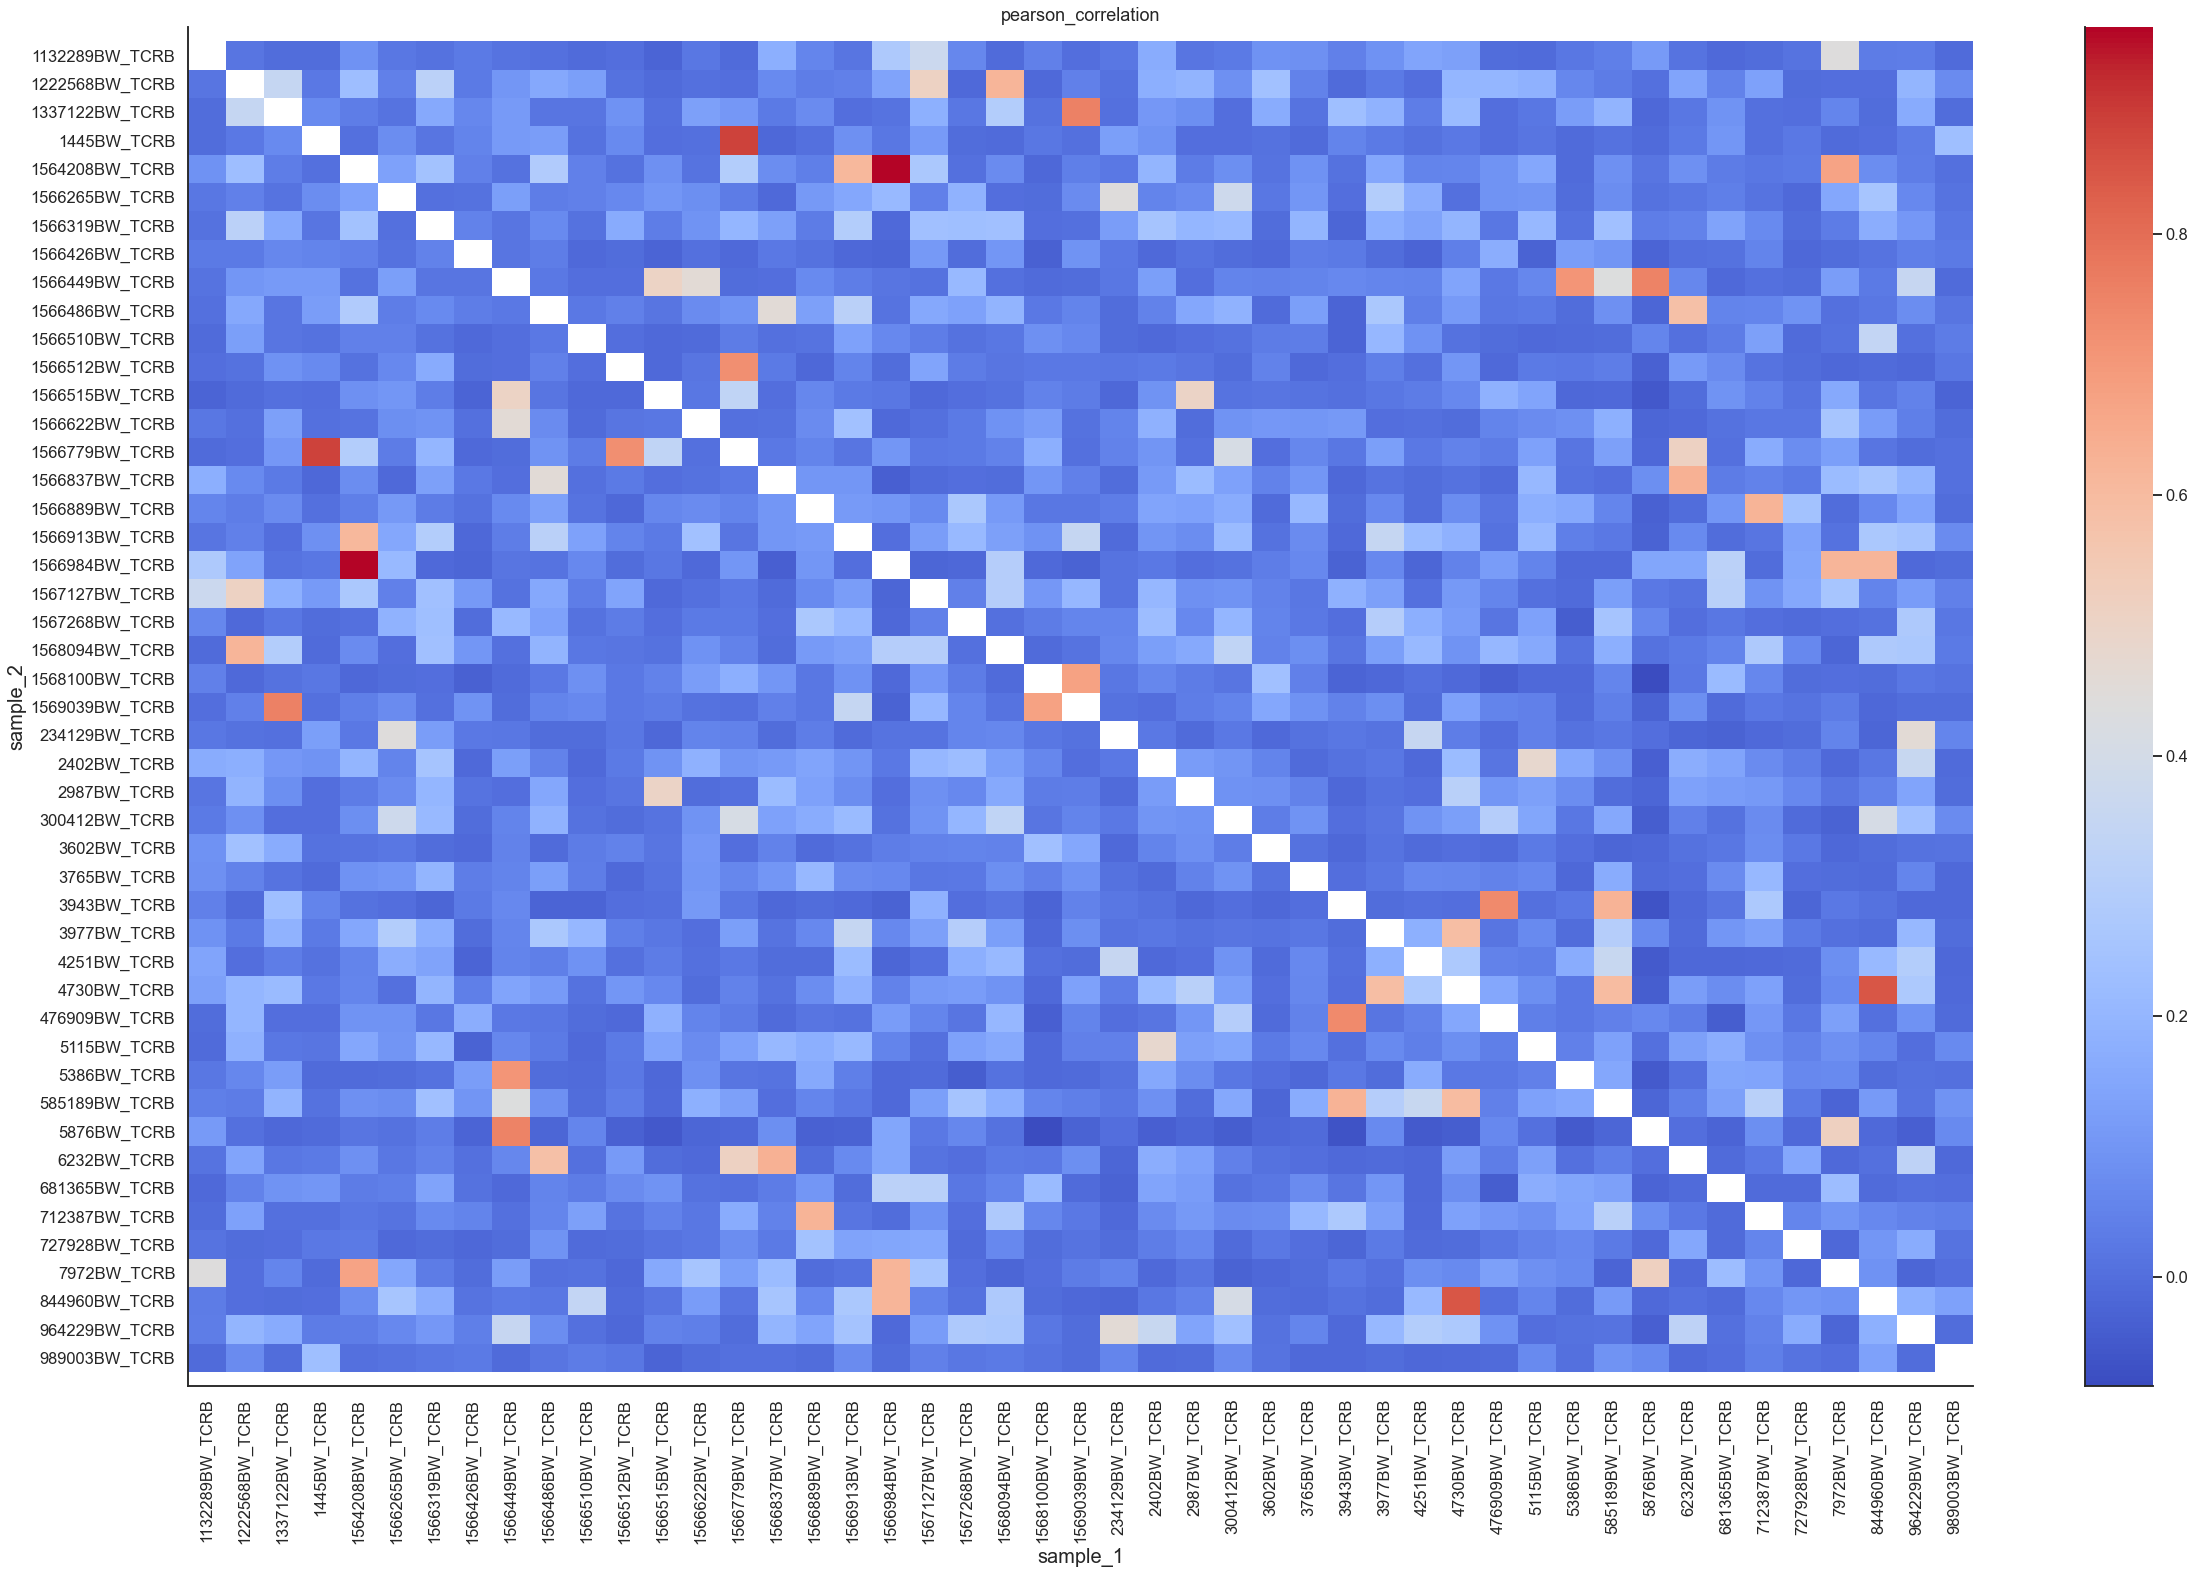

In [31]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_pearson_correlation_freq['pearson_correlation'] = df_pearson_correlation_freq['pearson_correlation'].astype(
    float)
result = df_pearson_correlation_freq.pivot(
    index='sample_2', columns='sample_1', values='pearson_correlation')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('pearson_correlation')


Overlap analysis 7.1 - Relative overlap diversity (result table)

In [33]:
df_relative_overlap_diversity = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'relative_overlap_diversity'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        relative_overlap_diversity = df_overlap.shape[0] / (
            df_sample1.shape[0] * df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'relative_overlap_diversity': relative_overlap_diversity})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'relative_overlap_diversity': relative_overlap_diversity})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_relative_overlap_diversity = pd.concat(
        [df_relative_overlap_diversity, df_data], copy=False)

display(df_relative_overlap_diversity)


,sample_1,sample_2,relative_overlap_diversity
0,6232BW_TCRB,5115BW_TCRB,4.317742e-09
0,5115BW_TCRB,6232BW_TCRB,4.317742e-09
0,6232BW_TCRB,989003BW_TCRB,4.831447e-09
0,989003BW_TCRB,6232BW_TCRB,4.831447e-09
0,6232BW_TCRB,7972BW_TCRB,5.158763e-09
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,5.595345e-09
0,1566449BW_TCRB,1566265BW_TCRB,5.889200e-09
0,1566265BW_TCRB,1566449BW_TCRB,5.889200e-09
0,3602BW_TCRB,1566265BW_TCRB,5.443067e-09


Overlap analysis 7.2 - Relative overlap diversity (heatmap)

Text(0.5, 1.0, 'relative_overlap_diversity')

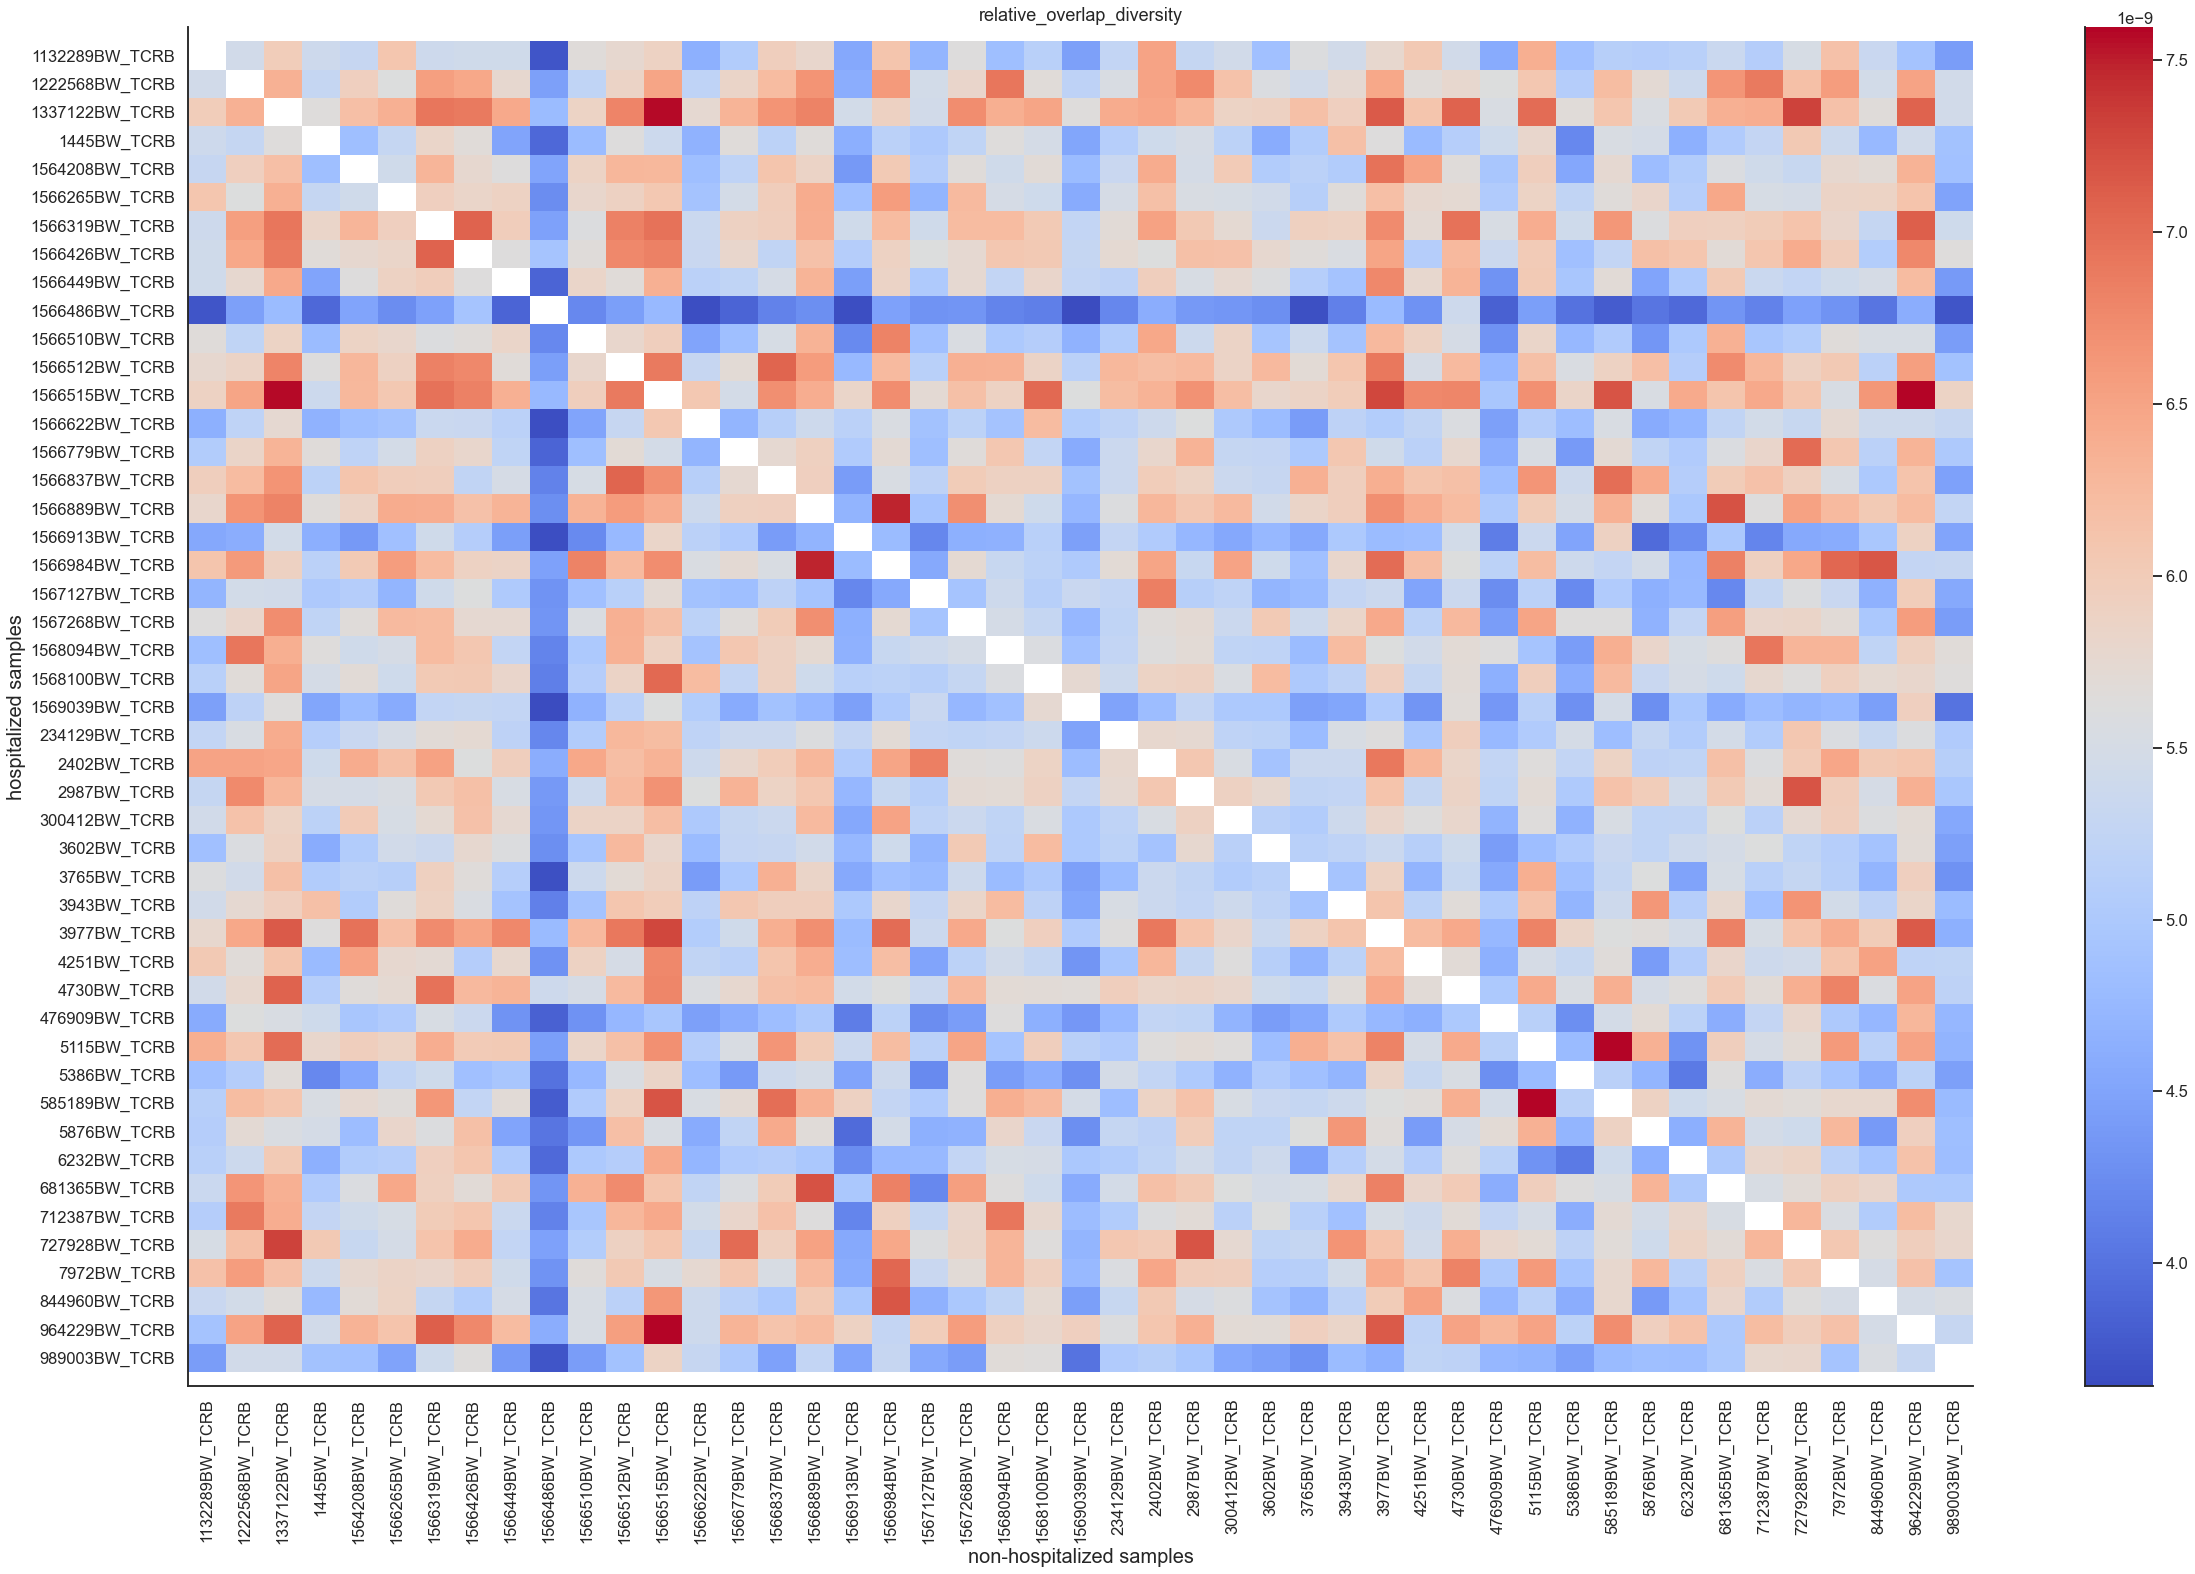

In [34]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_relative_overlap_diversity['relative_overlap_diversity'] = df_relative_overlap_diversity['relative_overlap_diversity'].astype(
    float)
result = df_relative_overlap_diversity.pivot(
    index='sample_2', columns='sample_1', values='relative_overlap_diversity')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('non-hospitalized samples', fontsize=20)
ax.set_ylabel('hospitalized samples', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('relative_overlap_diversity')


Overlap analysis 8.1 - Geometric mean of relative overlap frequencies (result table)

In [35]:
df_geometric_mean_of_relative_overlap_frequencies = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'geometric_mean_of_relative_overlap_frequencies'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = (df_overlap['freq_1'].sum() * df_overlap['freq_2'].sum())**0.5

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'geometric_mean_of_relative_overlap_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'geometric_mean_of_relative_overlap_frequencies': result})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_geometric_mean_of_relative_overlap_frequencies = pd.concat(
        [df_geometric_mean_of_relative_overlap_frequencies, df_data], copy=False)

df_geometric_mean_of_relative_overlap_frequencies


,sample_1,sample_2,geometric_mean_of_relative_overlap_frequencies
0,6232BW_TCRB,5115BW_TCRB,0.000568
0,5115BW_TCRB,6232BW_TCRB,0.000568
0,6232BW_TCRB,989003BW_TCRB,0.001063
0,989003BW_TCRB,6232BW_TCRB,0.001063
0,6232BW_TCRB,7972BW_TCRB,0.000952
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.002468
0,1566449BW_TCRB,1566265BW_TCRB,0.002458
0,1566265BW_TCRB,1566449BW_TCRB,0.002458
0,3602BW_TCRB,1566265BW_TCRB,0.001893


Overlap analysis 8.2 - Geometric mean of relative overlap frequencies (heatmap)

Text(0.5, 1.0, 'geometric_mean_of_relative_overlap_frequencies')

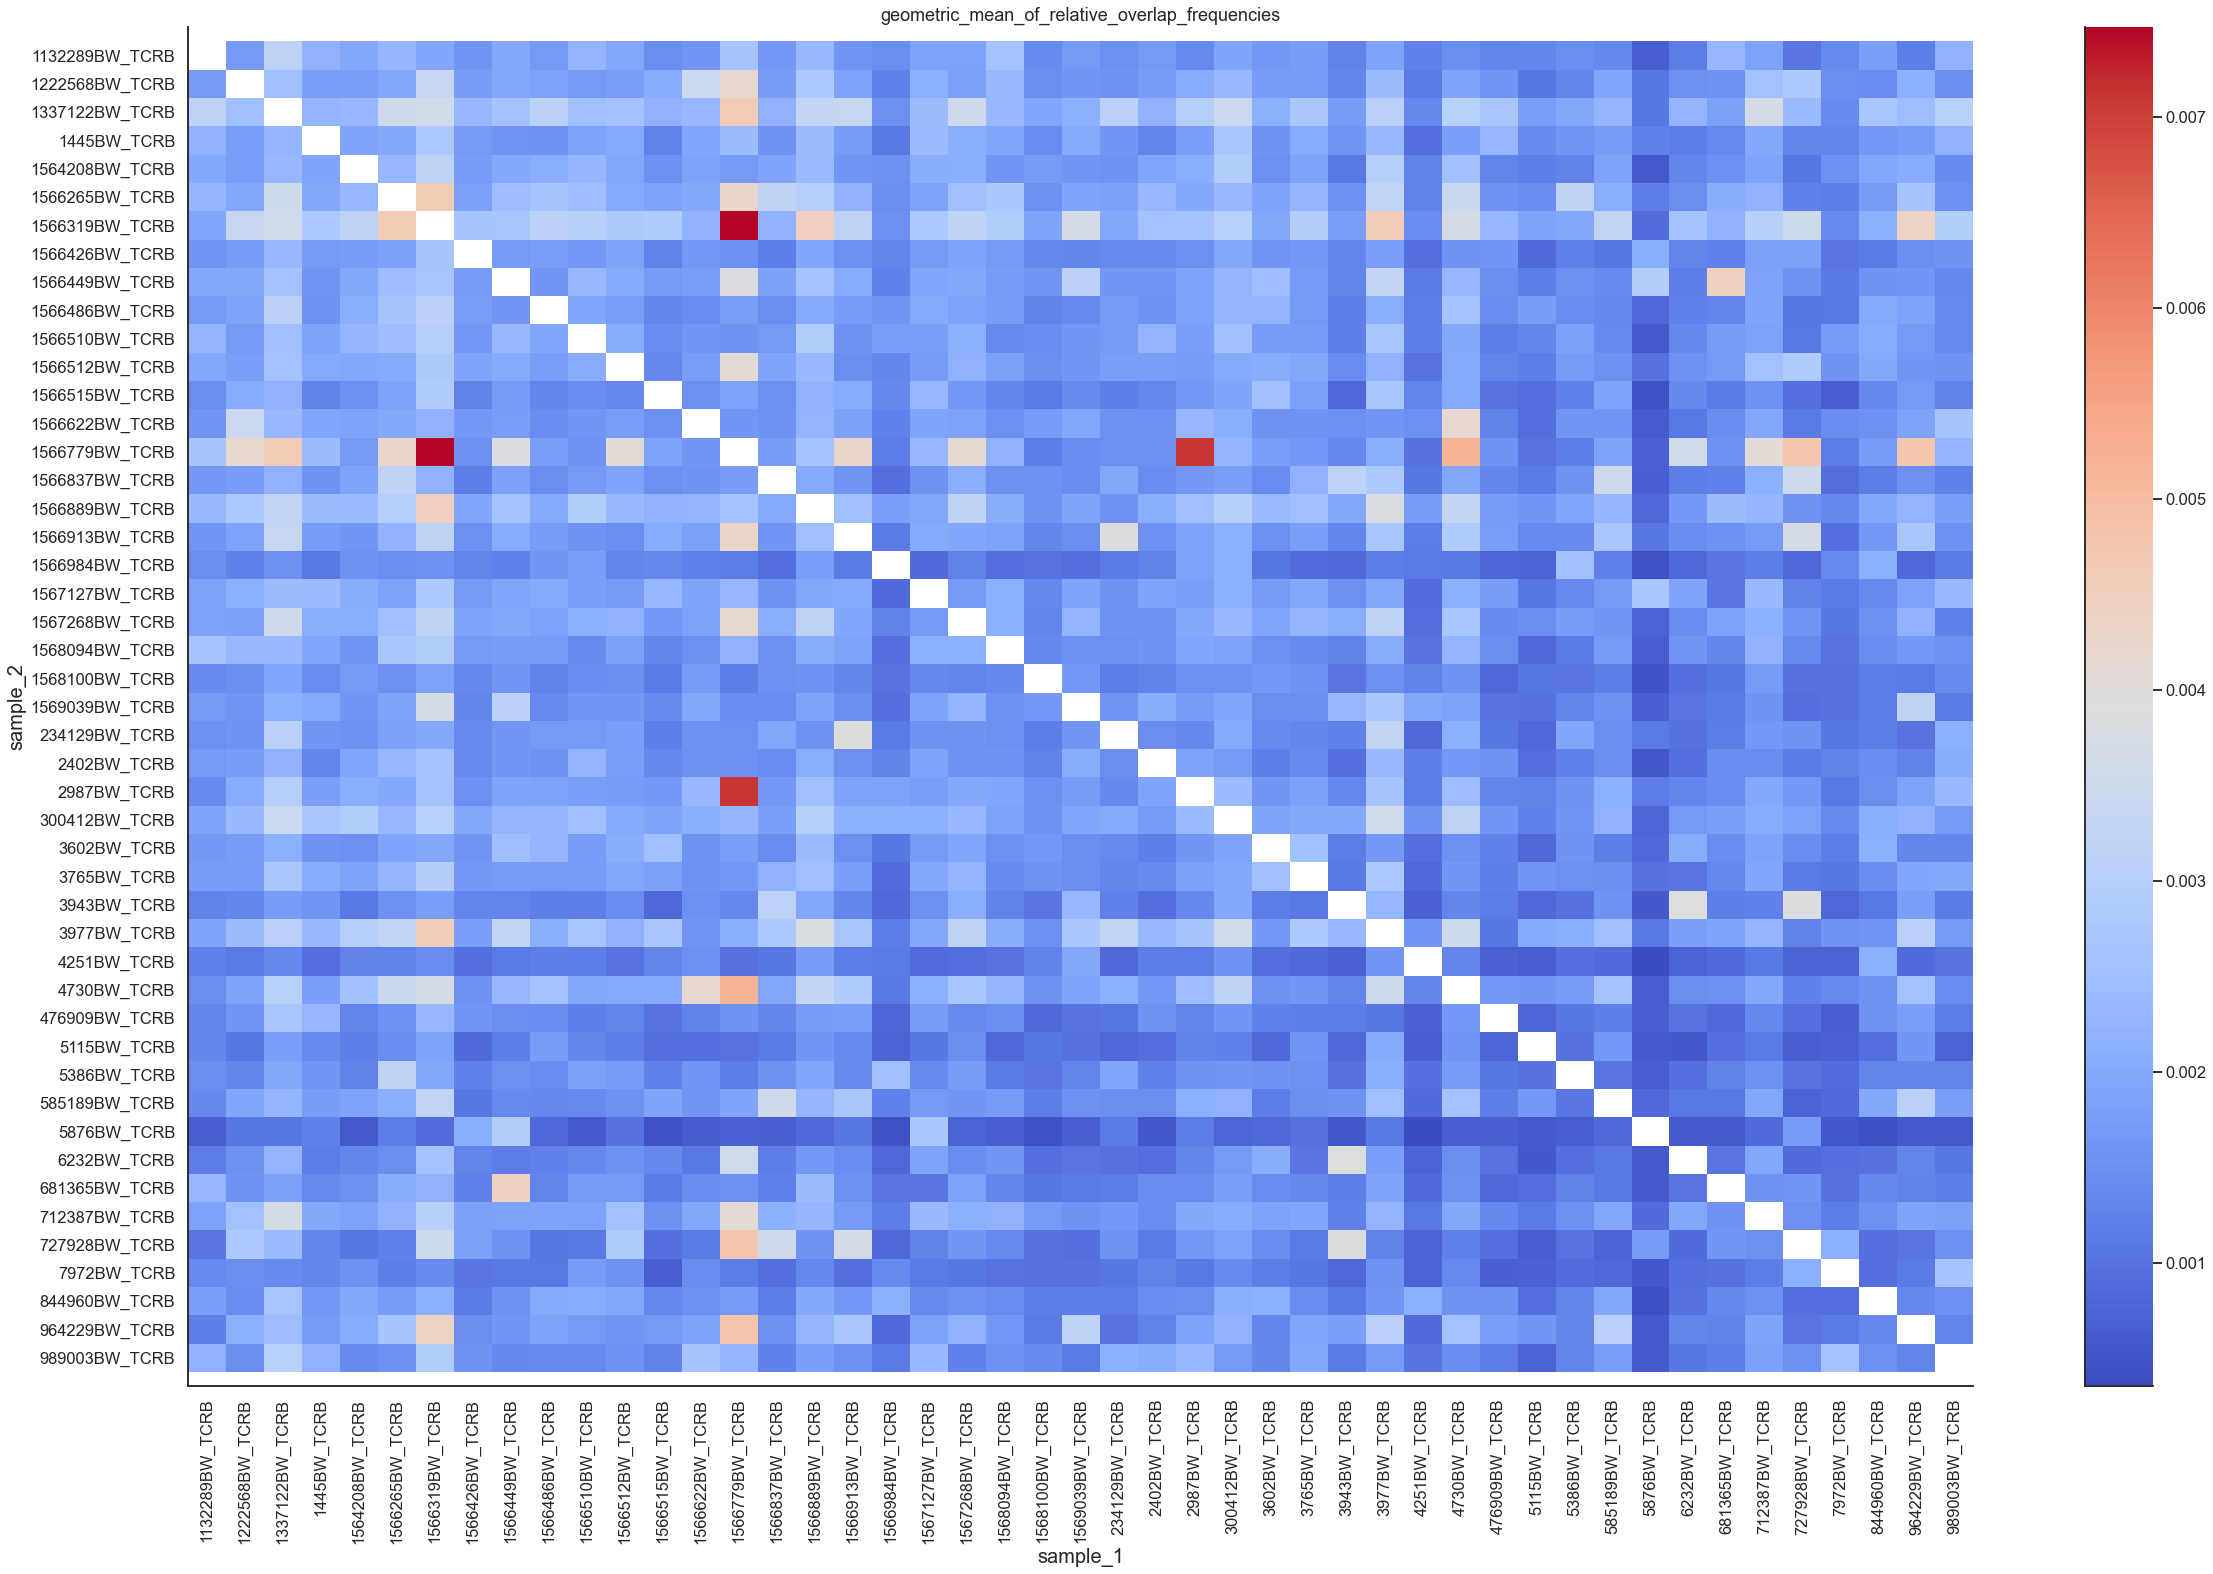

In [36]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_geometric_mean_of_relative_overlap_frequencies['geometric_mean_of_relative_overlap_frequencies'] = df_geometric_mean_of_relative_overlap_frequencies[
    'geometric_mean_of_relative_overlap_frequencies'].astype(float)
    
result = df_geometric_mean_of_relative_overlap_frequencies.pivot(
    index='sample_2', columns='sample_1', values='geometric_mean_of_relative_overlap_frequencies')
    
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('geometric_mean_of_relative_overlap_frequencies')


Overlap analysis 9.1 - Сlonotype-wise sum of geometric mean frequencies (result table)

In [37]:
df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'clonotype_wise_sum_of_geometric_mean_frequencies'])

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = ((df_overlap['freq_1']*df_overlap['freq_2'])**0.5).sum()

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.concat(
        [df_clonotype_wise_sum_of_geometric_mean_frequencies, df_data], copy=False)

df_clonotype_wise_sum_of_geometric_mean_frequencies


,sample_1,sample_2,clonotype_wise_sum_of_geometric_mean_frequencies
0,6232BW_TCRB,5115BW_TCRB,0.000480
0,5115BW_TCRB,6232BW_TCRB,0.000480
0,6232BW_TCRB,989003BW_TCRB,0.000876
0,989003BW_TCRB,6232BW_TCRB,0.000876
0,6232BW_TCRB,7972BW_TCRB,0.000741
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.001736
0,1566449BW_TCRB,1566265BW_TCRB,0.001943
0,1566265BW_TCRB,1566449BW_TCRB,0.001943
0,3602BW_TCRB,1566265BW_TCRB,0.001634


Overlap analysis 9.2 - Clonotype-wise sum of geometric mean frequencies (heatmap)

Text(0.5, 1.0, 'clonotype_wise_sum_of_geometric_mean_frequencies')

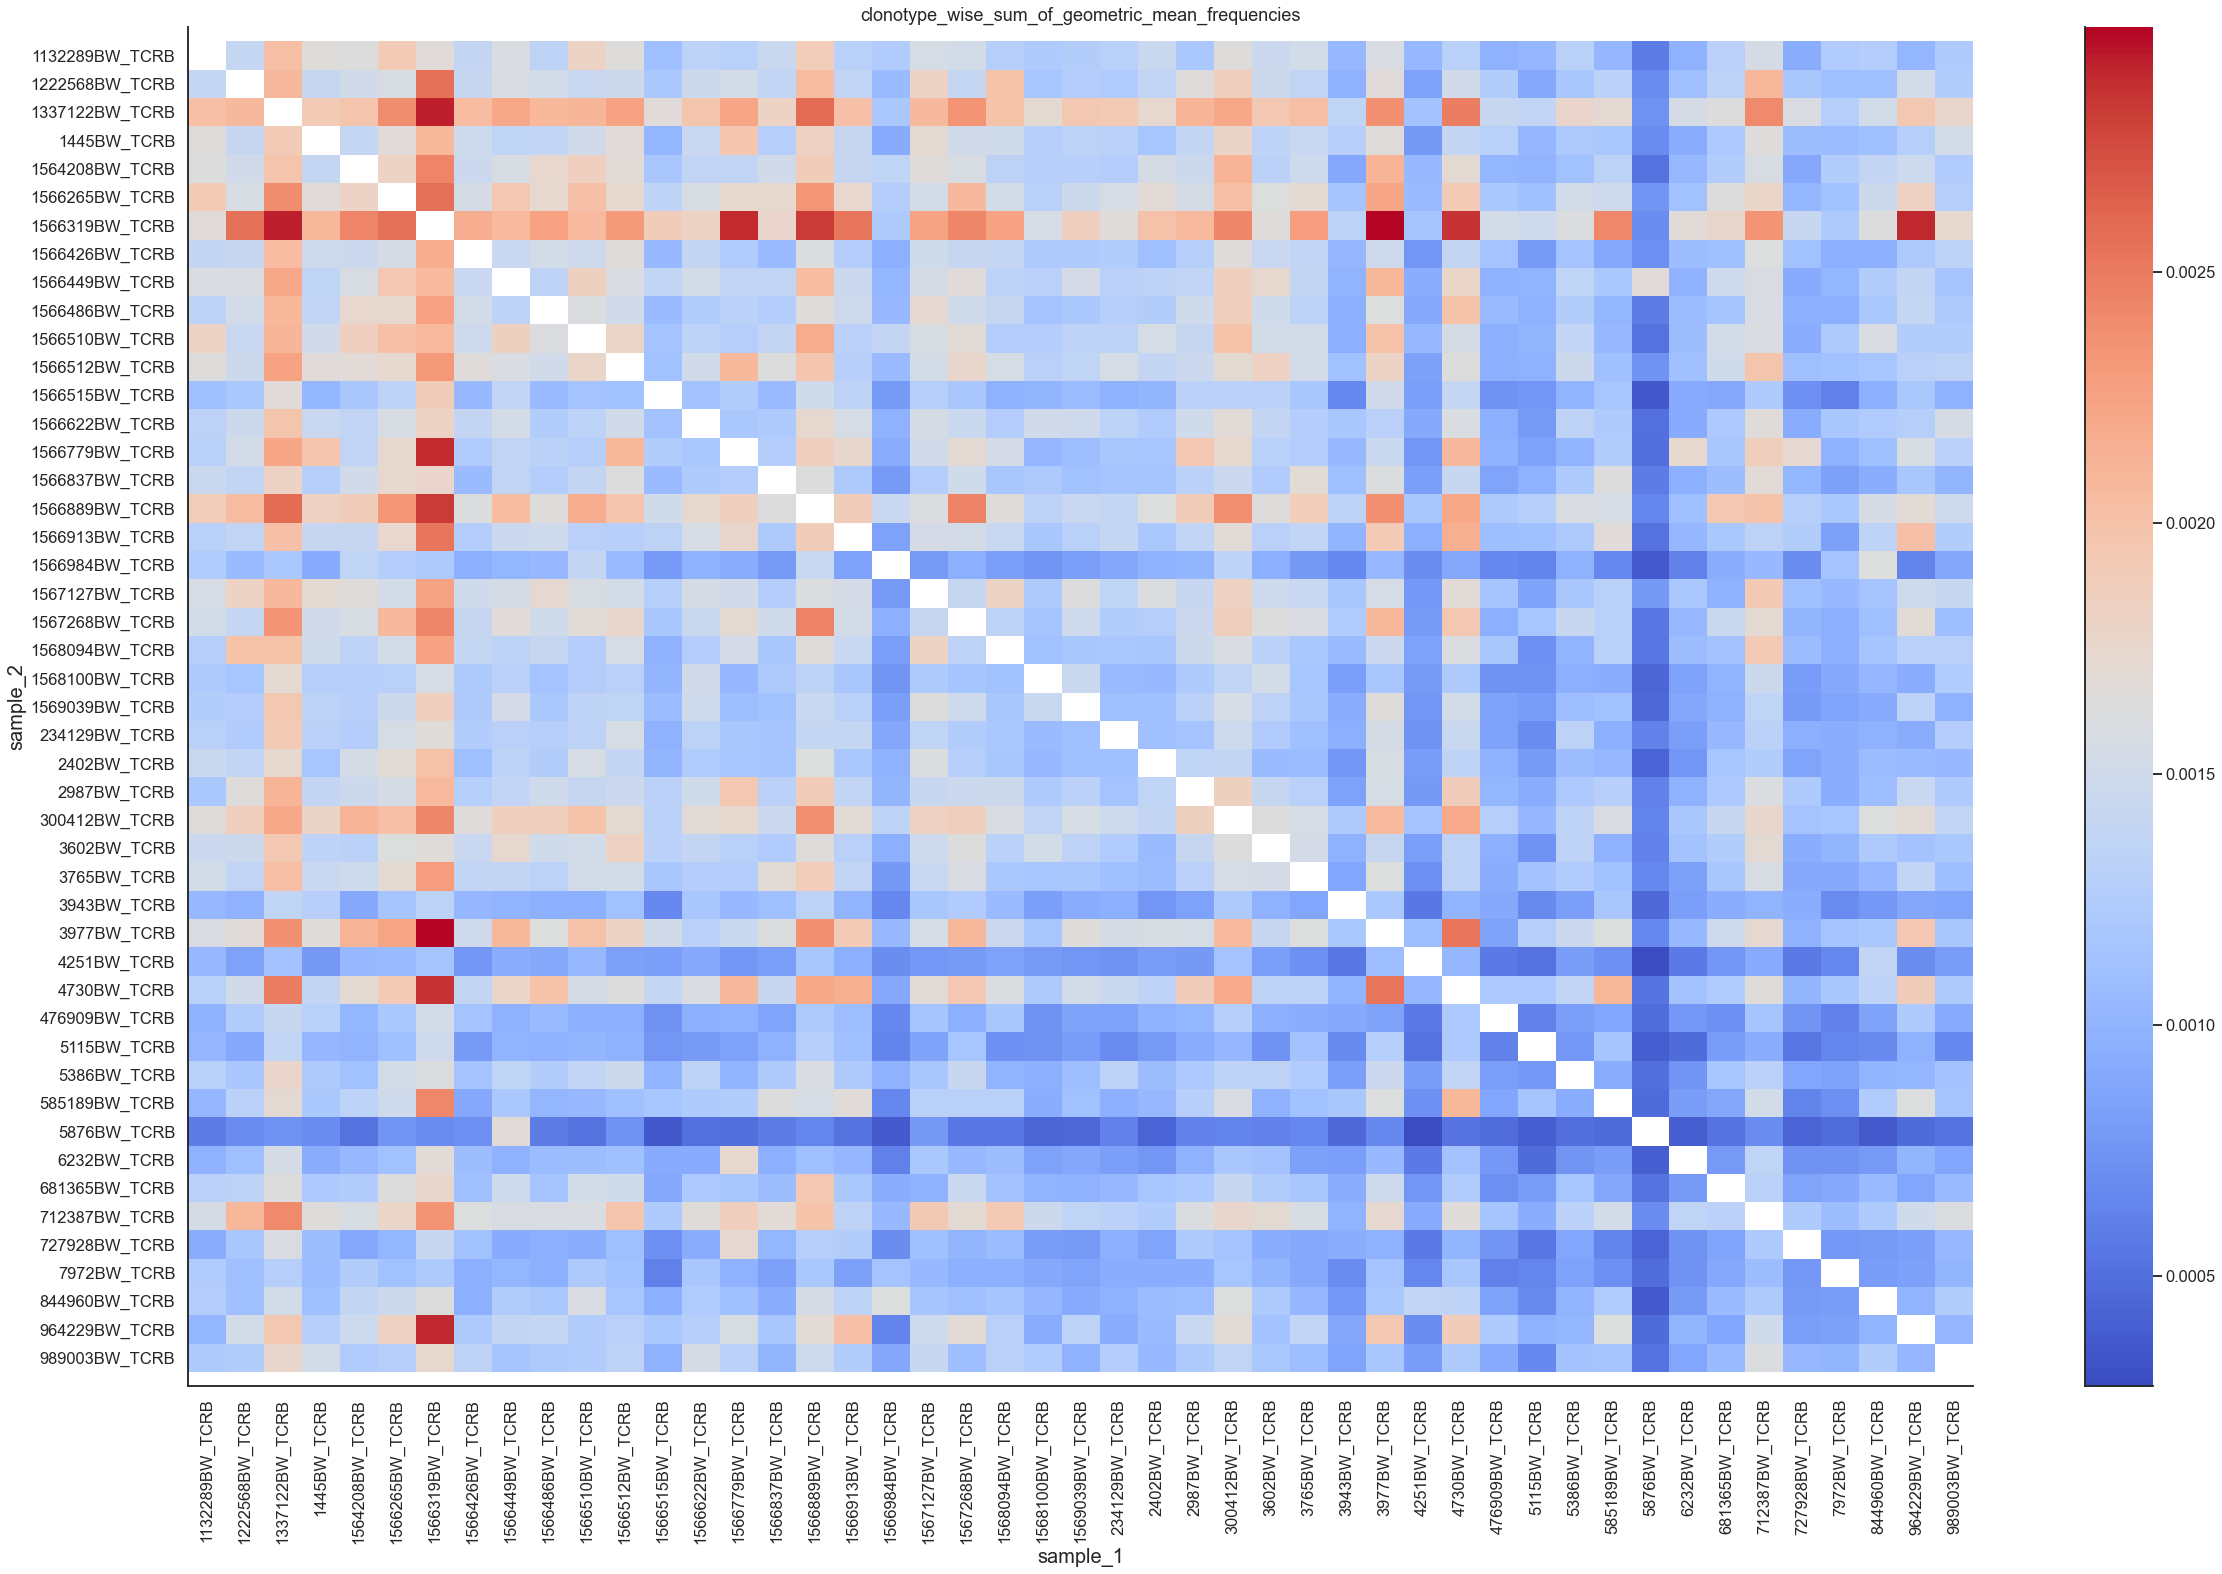

In [38]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_clonotype_wise_sum_of_geometric_mean_frequencies['clonotype_wise_sum_of_geometric_mean_frequencies'] = df_clonotype_wise_sum_of_geometric_mean_frequencies[
    'clonotype_wise_sum_of_geometric_mean_frequencies'].astype(float)
result = df_clonotype_wise_sum_of_geometric_mean_frequencies.pivot(
    index='sample_2', columns='sample_1', values='clonotype_wise_sum_of_geometric_mean_frequencies')
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('clonotype_wise_sum_of_geometric_mean_frequencies')


Overlap analysis 10.1 - Jensen-Shannon divergence of variable segment usage distributions (result table)

In [39]:
df_jensen_shannon_divergence = pd.DataFrame(
    columns=['sample_1', 'sample_2', 'jensen_shannon_divergence'])


def kl_divergence(p, q):
    return -np.sum(p*np.log2(q/p))


def js_divergence(p, q):
    m = (1/2)*(p + q)
    return (1/2) * kl_divergence(p, m) + (1/2) * kl_divergence(q, m)


for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_sample1_v = df_sample1.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_1': 'sum'})
        df_sample2_v = df_sample2.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_2': 'sum'})

        df_JSD_combine = pd.merge(df_sample1_v, df_sample2_v, on=['v'])

        JSD_sample1 = df_JSD_combine[['sumfreq_1']].to_numpy()
        JSD_sample2 = df_JSD_combine[['sumfreq_2']].to_numpy()

        result = js_divergence(JSD_sample1, JSD_sample2)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jensen_shannon_divergence': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jensen_shannon_divergence': result})

    df_data = pd.DataFrame(data, index=np.zeros(len(data), dtype=int))
    df_jensen_shannon_divergence = pd.concat(
        [df_jensen_shannon_divergence, df_data], copy=False)

df_jensen_shannon_divergence


,sample_1,sample_2,jensen_shannon_divergence
0,6232BW_TCRB,5115BW_TCRB,0.147922
0,5115BW_TCRB,6232BW_TCRB,0.147922
0,6232BW_TCRB,989003BW_TCRB,0.031911
0,989003BW_TCRB,6232BW_TCRB,0.031911
0,6232BW_TCRB,7972BW_TCRB,0.040263
...,...,...,...
0,3602BW_TCRB,1566449BW_TCRB,0.025318
0,1566449BW_TCRB,1566265BW_TCRB,0.045227
0,1566265BW_TCRB,1566449BW_TCRB,0.045227
0,3602BW_TCRB,1566265BW_TCRB,0.019404


Overlap analysis 10.2 - Jensen-Shannon divergence of variable segment usage distributions (heatmap)

Text(0.5, 1.0, 'jensen_shannon_divergence')

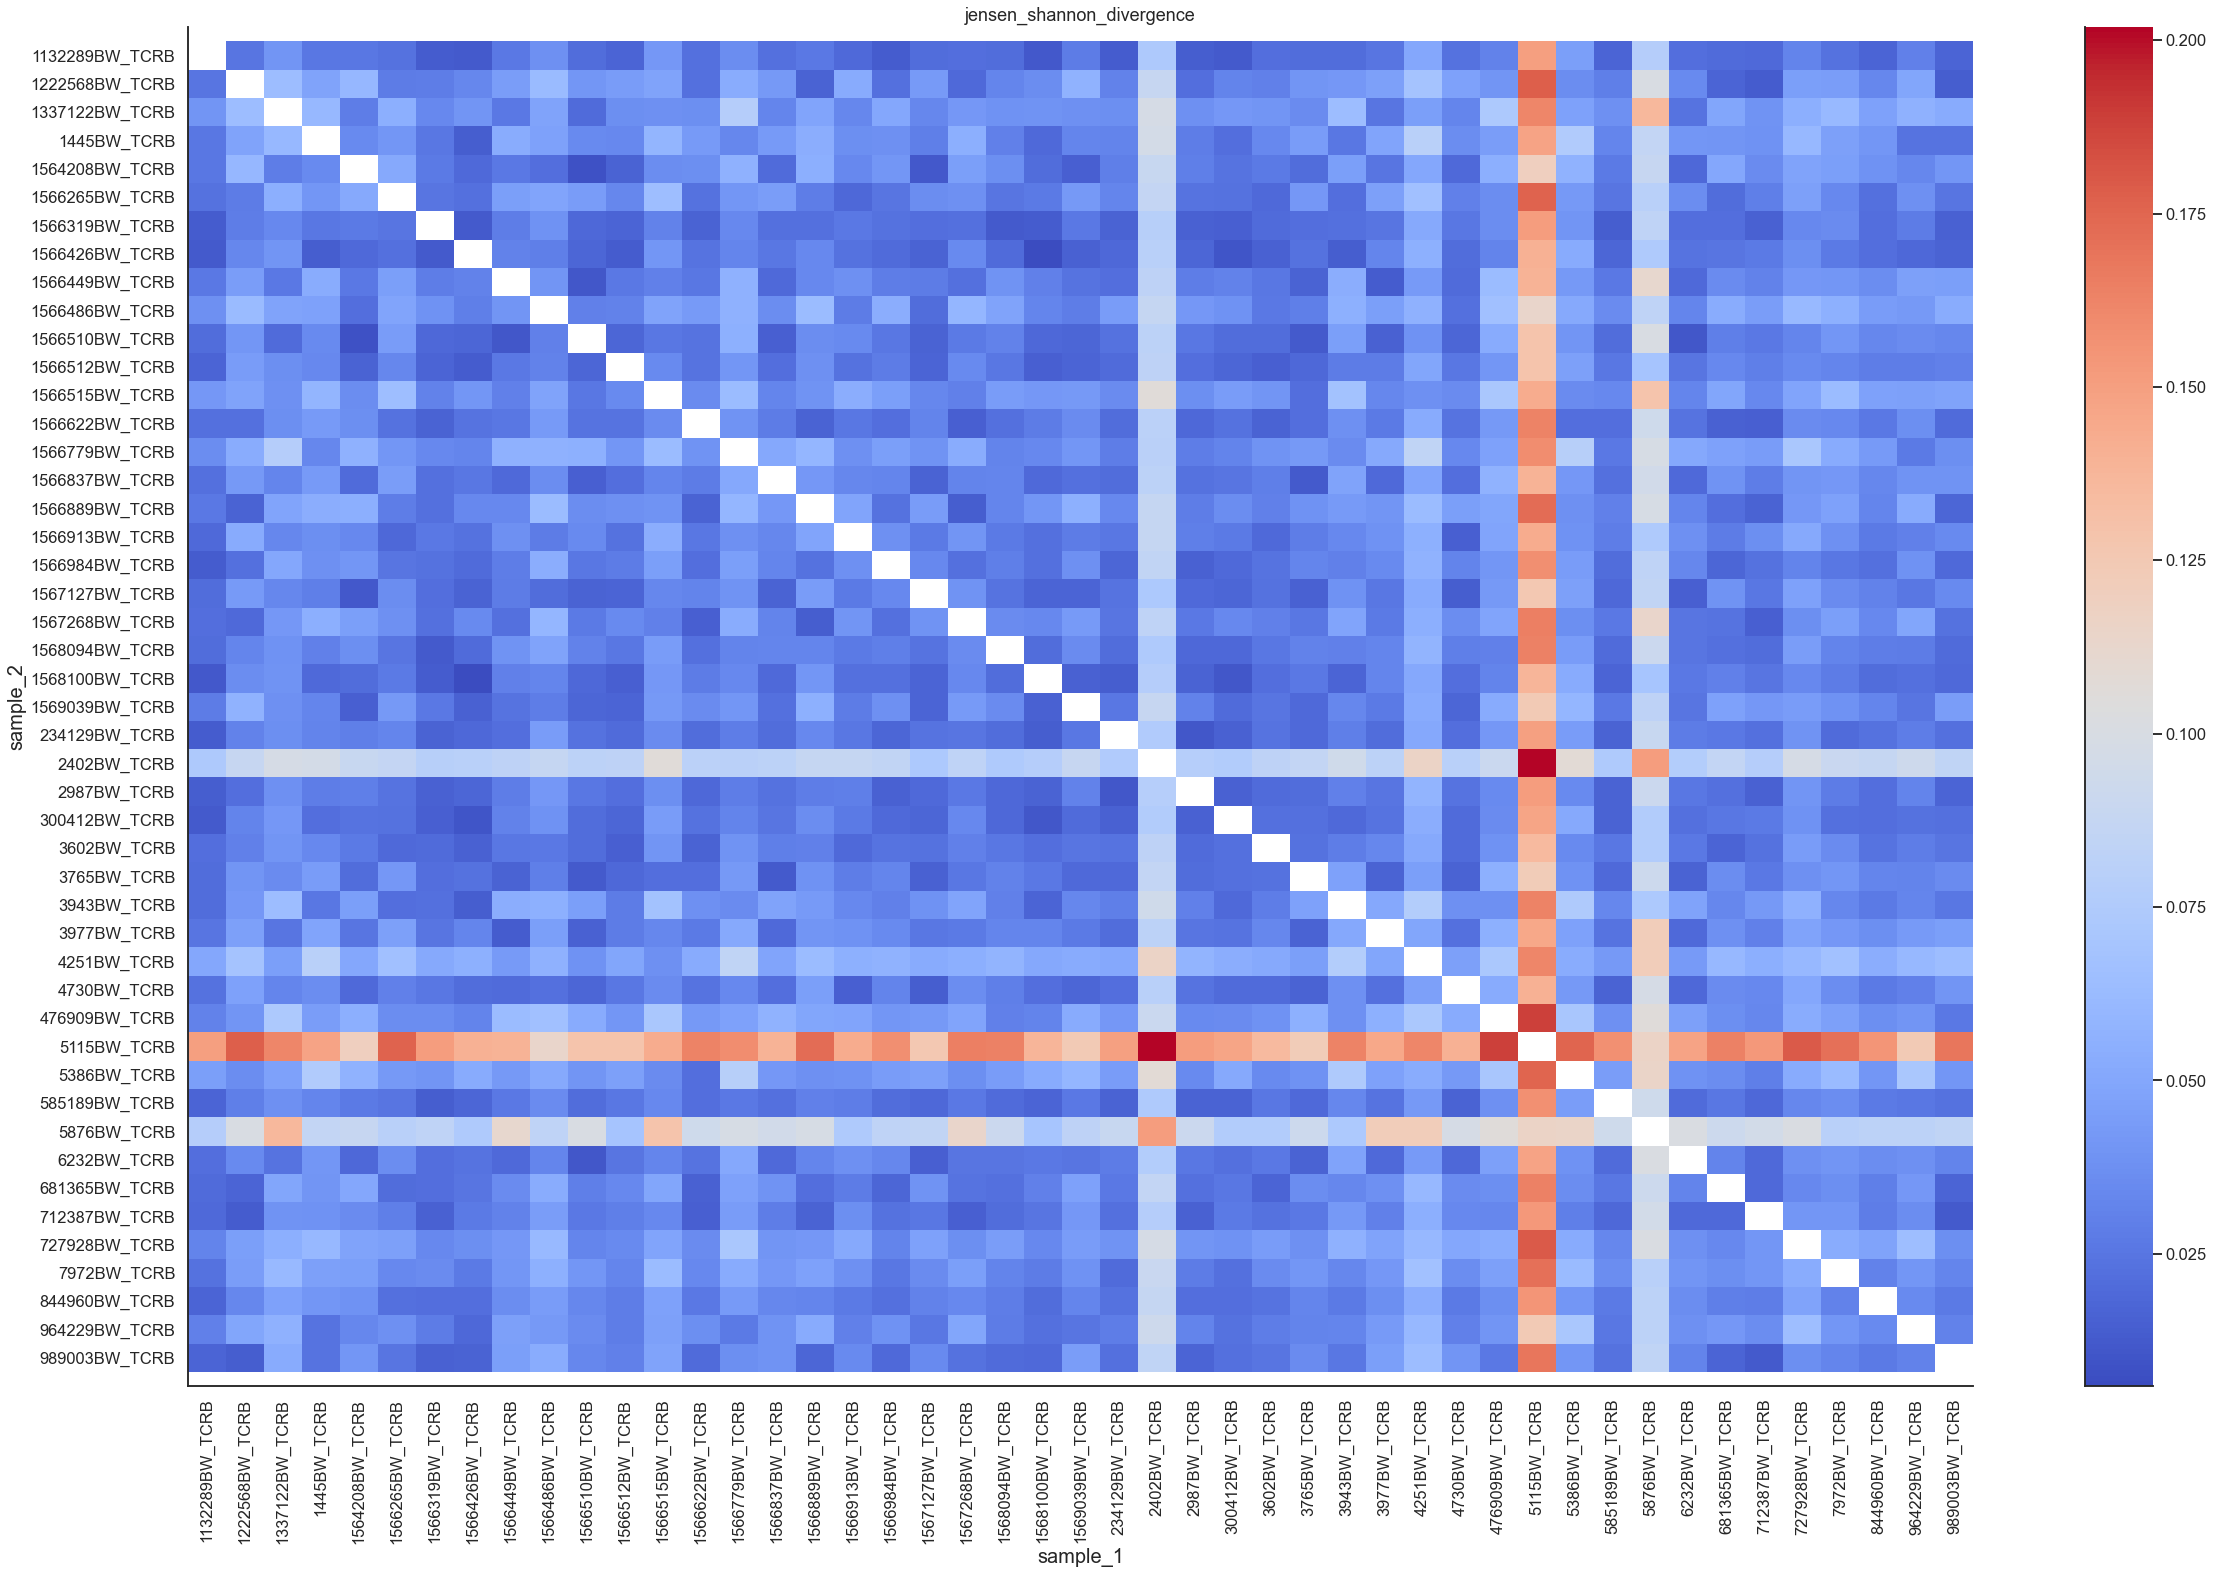

In [40]:
# set aesthetics
plt.style.use(['ggplot', 'seaborn-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# generate axes
df_jensen_shannon_divergence['jensen_shannon_divergence'] = df_jensen_shannon_divergence['jensen_shannon_divergence'].astype(
    float)

result = df_jensen_shannon_divergence.pivot(
    index='sample_2', columns='sample_1', values='jensen_shannon_divergence')
    
ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
sns.despine()
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('jensen_shannon_divergence')
